<a href="https://colab.research.google.com/gist/YiHui-Liu/1ed2f9484c5e20587d016e5d7854c273/wechatmsganalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QQ聊天记录分析 QQMsgAnalysis
依照 [WeChatMsg](https://github.com/LC044/WeChatMsg) 的教程导出 `csv` 文件，只需要导出文本即可。

点击左侧的文件，上传 `csv` 文件并且重命名为 `msg.csv`。

与原始的微信聊天记录分析类似，不过导出之后需要注意的是将，所有发送者的名字统一替换为某某（qq号）的格式，这样方便处理，同时因为qq的聊天记录是每次更改名称之后都会有不同的名字，所以需要替换多次来统一命名，然后我们需要聊天记录的头部删除，只保留一般格式的聊天记录


In [1]:
!pip install numpy seaborn pandas wordcloud tqdm paddlepaddle paddlenlp

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
     ----- ------------------------------- 41.0/294.9 kB 991.0 kB/s eta 0:00:01
     --------------- ---------------------- 122.9/294.9 kB 1.4 MB/s eta 0:00:01
     ------------------------------ ------- 235.5/294.9 kB 1.6 MB/s eta 0:00:01
     -------------------------------------- 294.9/294.9 kB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
      --------------------------------------- 0.3/11.6 MB 5.7 MB/s eta 0:00:02
     - -------------------------------------- 0.6/11.6 MB 5.9 MB/s eta 0:00:02
     -- ------------------------------------- 0.8/11.6 MB 6.7 MB/s eta 0:00:02
     --- ------------------------------------ 1.0/11.6 MB 5.7 MB/s eta 0:00:02
     ---- ----------------------------------- 1.2/11.6 MB 5.4 MB/s eta 0:00:02
     ---- ----------------------------------- 1.4/11.6 MB 5.3 MB/s eta 0:00:02



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## 准备阶段
### 引入包
* pandas: 基础数据框架
* matplotlib & seaborn: 主要绘图框架
* jieba: 中文分词
* wordcloud: 词云
* paddlenlp: 情感分析

In [94]:
import re
import time
import numpy as np
import pandas as pd
import jieba
import jieba.posseg as pseg
from PIL import Image
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.transforms as mtransforms
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
from tqdm import tqdm
from paddlenlp import Taskflow

### 绘图设置

In [95]:
sns.set_theme(style="ticks")
font = "simsun.ttc"
fp = fm.FontProperties(fname=font)
plt.rcParams["axes.unicode_minus"] = False

### 代码处理qq文件

In [97]:
import re
import csv
def process_chat_records(input_file, output_csv):
    # 读取聊天记录
    with open(input_file, 'r', encoding='utf-8') as file:
        chat_lines = file.readlines()

    # 初始化CSV数据
    csv_data = []

    # 正则表达式匹配聊天记录中的日期、时间、发送者和内容
    pattern = re.compile(r'(\d{4}-\d{2}-\d{2} \d{1,2}:\d{2}:\d{2}) (.+?)\((\d+)\)')

    # 处理每一行聊天记录
    current_sender = None
    current_content = ""  # 添加这一行
    for line in chat_lines:
        match = pattern.match(line)
        if match:
            # 如果当前存在发送者，将之前缓存的内容添加到CSV数据中
            if current_sender:
                if not current_content.strip():
                    current_content = "（信息回复或者分享）"
                csv_data.append([current_sender, match.group(1), current_content.strip()])
            
            # 更新当前发送者
            current_sender = match.group(2) + '(' + match.group(3) + ')'
            
            # 重置当前内容
            current_content = ""
        else:
            # 没有匹配到日期时间信息，将整行作为内容添加到当前内容中
            current_content += line

    # 将CSV数据写入文件
    with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
        csv_writer = csv.writer(csvfile)
        # 写入表头
        csv_writer.writerow(['Member', 'StrTime', 'StrContent'])
        # 写入数据
        csv_writer.writerows(csv_data)

In [98]:
#resolving_by_user("2.txt", "output_resolved_data.csv")
process_chat_records("2.txt", "output_chat_log.csv")


### 人名标签

In [99]:
labels = ["ZMX", "LJM"]

### 数据读取
* `filePath`: 消息记录文件的路径
* `dStart`: 开始的时间
* `dEnd`: 结束的时间
* `tZone`: 时区，例如北京时间为 `+8`

不考虑这么麻烦qq导出的没有时区信息

In [100]:
filePath = "output_chat_log.csv"
dStart = "2023-01-01 23:43:41"
dEnd = "2024-02-04 20:50:12"

In [101]:
df = pd.read_csv(filePath, encoding="utf-8")



# Convert the 'StrTime' column to datetime
df["StrTime"] = pd.to_datetime(df["StrTime"])

# Extract time information
df["year"] = df["StrTime"].dt.year
df["month"] = df["StrTime"].dt.month
df["day"] = df["StrTime"].dt.day
df["hour"] = df["StrTime"].dt.hour
df["minute"] = df["StrTime"].dt.minute
df["second"] = df["StrTime"].dt.second
                       
conditions = [
    df["StrContent"].str.contains("（信息回复或者分享）"),
    df["StrContent"].str.contains("\[图片\]"),
    df["StrContent"].str.contains("\[表情\]")
]

# 创建对应的值列表
values = [9, 3, 47]

# 使用 numpy 的 select 函数根据条件设置新列 "Type"
df["Type"] = np.select(conditions, values, default=1)
# 添加名为 "Count" 的新列，每一行都设置为1
df["Count"] = 1

##在这里改成自己和对方的名称和qq号
member_values = ['友人A(1111111111)', '友人B(2333333333)']
df['IsSender'] = np.where(df['Member'] == '友人A(1111111111)', 0,
                          np.where(df['Member'] == '友人B(233333333)', 1, np.nan))

dfs = [df.query("Member == @value") for value in member_values]


### 消息过滤

In [102]:
def textFilter(text: str):
    text = text.lower()
    # try:
    #     co = re.compile("[\U00010000-\U0010ffff]")
    # except re.error:
    #     co = re.compile("[\uD800-\uDBFF][\uDC00-\uDFFF]")
    # text = co.sub(" ", text)
    co = re.compile("\[[\u4e00-\u9fa5]+\]")
    return co.sub(" ", text)

### 获取文本消息

In [103]:
texts = [
    [textFilter(i) for i in dfs[0].query("Type == 1")["StrContent"].to_list()],
    [textFilter(i) for i in dfs[1].query("Type == 1")["StrContent"].to_list()],
]

## 消息频率分析
### 类型分析
根据消息的类型进行分类，可以看出喜欢发送的消息类型，同时也可以看出谁发的多
* 1 = Text
* 3 = Image
* 34 = Voice
* 43 = Video
* 47 = Sticker
* 48 = Location
* 10000 = System

qq里面无法导出* 34 = Voice* 43 = Video信息所以不展示

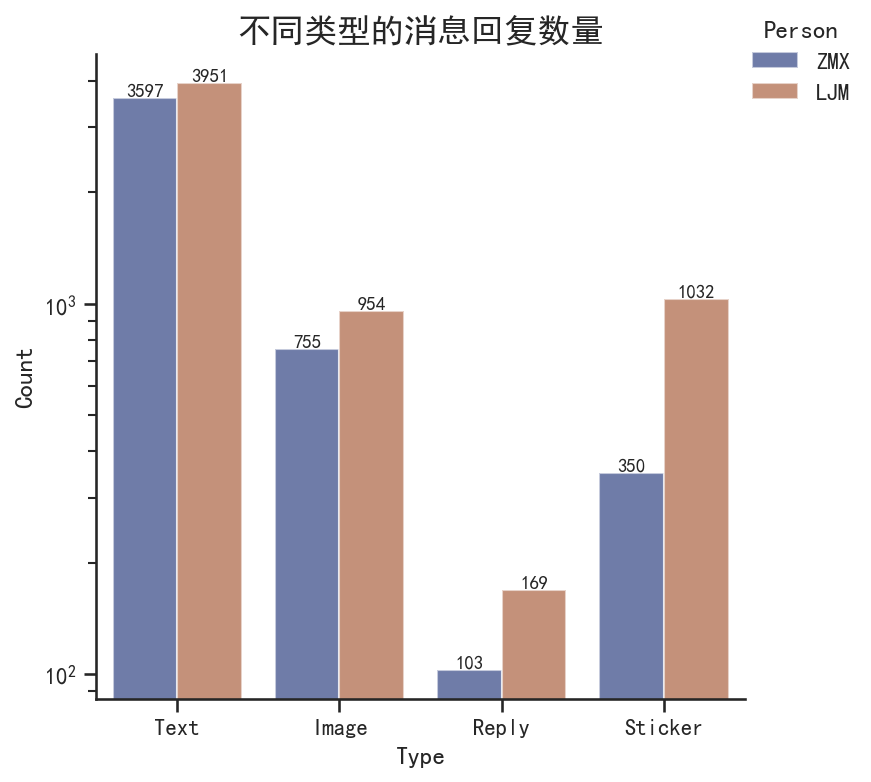

In [104]:
data = {}
for i in range(2):
    data[labels[i]] = [
        len(dfs[i].query("Type == 1")),
        len(dfs[i].query("Type == 3")),
        len(dfs[i].query("Type == 9")),
        # len(dfs[i].query("Type == 43")),
        len(dfs[i].query("Type == 47")),
    ]

data = (
    # pd.DataFrame(data, index=["Text", "Image", "Voice", "Video", "Sticker"])
    pd.DataFrame(data, index=["Text", "Image","Reply", "Sticker"])
    .reset_index()
    .melt("index")
    .rename(columns={"index": "Type", "variable": "Person", "value": "Count"})
)
g = sns.catplot(data, kind="bar", x="Type", y="Count", hue="Person", palette="dark", alpha=0.6, height=6)

for ax in g.axes.ravel():
    for i in range(2):
        ax.bar_label(ax.containers[i], fontsize=9)

# # 在图片上增加文字批注
# for ax in g.axes.ravel():
#     # 设置批注的坐标和文本
#     ax.text(3, 1e4, "Video属性无法显示", ha='center', va='center', fontsize=9, color='red')

sns.move_legend(g, "upper right")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体
plt.title('不同类型的消息回复数量', fontsize=16)

plt.yscale("log")

g.figure.set_size_inches(6, 5)
g.figure.set_dpi(150)
plt.show()
plt.close()

### 消息长度分析
* `sN`: 设置显示范围：
$$
\mu + \mathrm{sN} * \sigma
$$
* `multiple`: 直方图堆叠格式

In [105]:
sN = 3
multiple = "dodge"

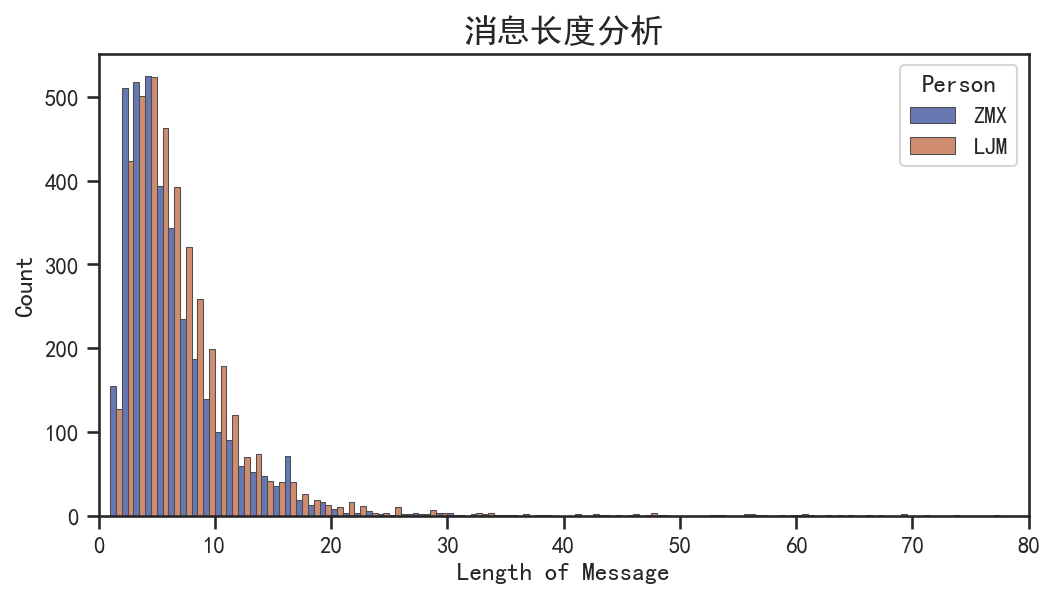

In [106]:
mu, std = 0, 0
data = {"Length": [], "Person": []}
for i in range(2):
    length = [len(textFilter(i)) for i in texts[i]]
    data["Length"] += length
    data["Person"] += [labels[i]] * len(length)
    if np.mean(length) + sN * np.std(length) > mu + std:
        mu, std = np.mean(length), np.std(length)
xlim = int(np.ceil(mu + sN * std))

data = pd.DataFrame(data)
bins = np.linspace(0, xlim, xlim + 1)

ax = sns.histplot(
    data=data,
    x="Length",
    hue="Person",
    bins=bins,
    multiple=multiple,
    edgecolor=".3",
    linewidth=0.5,
    palette="dark",
    alpha=0.6,
)
# ax.set_xlim(0, xlim)
# 我的信息上限太长了，展示出来不好看，所以设置了一个值
ax.set_xlim(0, 80)
ax.set_xlabel("Length of Message")

ax.figure.set_size_inches(8, 4)
ax.figure.set_dpi(150)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体
plt.title('消息长度分析', fontsize=16)
plt.show()
plt.close()

### 每日活跃分析
划分每日24小时内每小时发送的消息数，可以得知每天的活跃的时间段

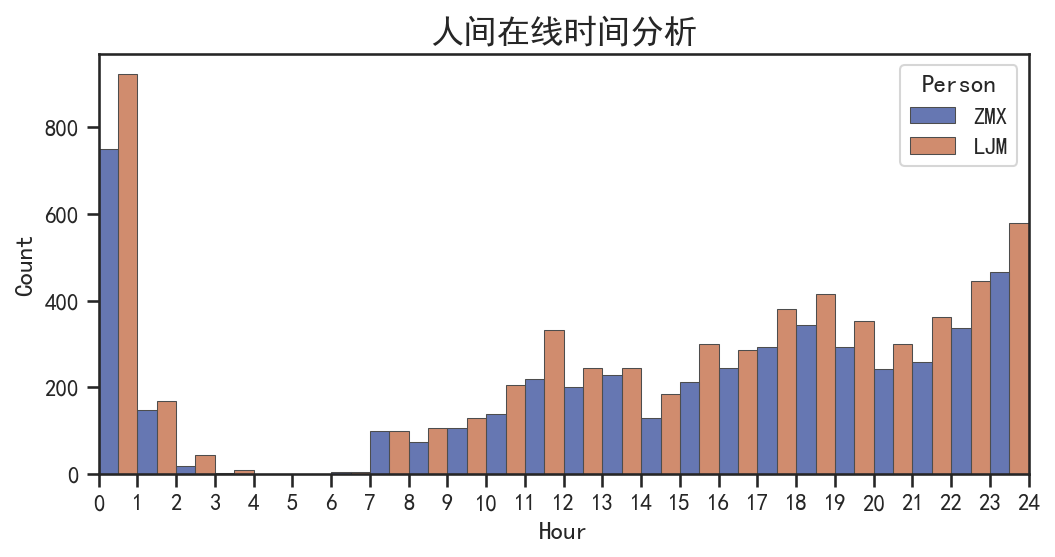

In [107]:
data = {"Time": [], "Person": []}
for i in range(2):
    hour = dfs[i]["hour"].to_list()
    data["Time"] += hour
    data["Person"] += [labels[i]] * len(hour)

data = pd.DataFrame(data)
bins = np.arange(0, 25, 1)

ax = sns.histplot(
    data=data,
    x="Time",
    hue="Person",
    bins=bins,
    multiple=multiple,
    edgecolor=".3",
    linewidth=0.5,
    palette="dark",
    alpha=0.6,
)
ax.set_xticks(bins)
ax.set_xticklabels(bins)
ax.set_xlabel("Hour")
ax.set_xlim(0, 24)
# sns.move_legend(ax, loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体
plt.title('人间在线时间分析', fontsize=16)
plt.subplots_adjust(top=0.9, bottom=0.2)

# for ax in g.axes.ravel():
#     # 设置批注的坐标和文本
#     ax.text(3, 1e4, "人间在线时间分析", ha='center', va='center', fontsize=16, color='red')
ax.figure.set_size_inches(8, 4)
ax.figure.set_dpi(150)
plt.show()
plt.close()

### 每周活跃分析
查看一周内从周一到周日每天发送的消息数

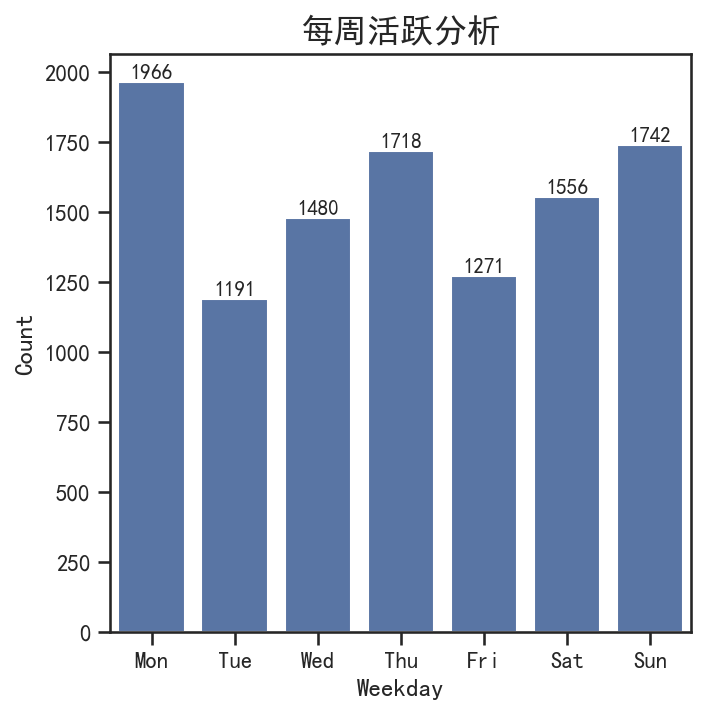

In [108]:


# grouper = pd.Grouper(key="day")
# data = df.groupby(grouper)["Count"].sum()
# data = data.sort_index()
# data.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# 使用 "year", "month", "day" 列创建一个 datetime 列
df["Date"] = pd.to_datetime(df[["year", "month", "day"]])

# 将 datetime 列转换为星期几，并添加一列 "Weekday"
df["Weekday"] = df["Date"].dt.day_name()
grouper = pd.Grouper(key="Weekday")
data = df.groupby(grouper)["Count"].sum()
data.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
# 创建一个包含所有星期信息的顺序列表
# weekday_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# # 根据星期几进行分组，统计累加
# result = df.groupby("Weekday")["Count"].sum().reindex(weekday_order)

ax = sns.barplot(data=data, errorbar=None)
ax.set_xlabel("Weekday")
ax.bar_label(ax.containers[0], fontsize=10)

ax.figure.set_size_inches(5, 5)
ax.figure.set_dpi(150)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体
plt.title('每周活跃分析', fontsize=16)
plt.show()
plt.close()

### 按周划分年度活跃分析
划分每7天内发送的消息数，可以得知每周的活跃的时间段
* `wTicks`: 每个刻度相差的数值
* `wStart`: **当年**第一个周一的日期
* `wEnd`: **次年**第一个周一的日期

In [109]:
wTicks = 500
wStart = "2023-02-04"
wEnd = "2024-03-11"

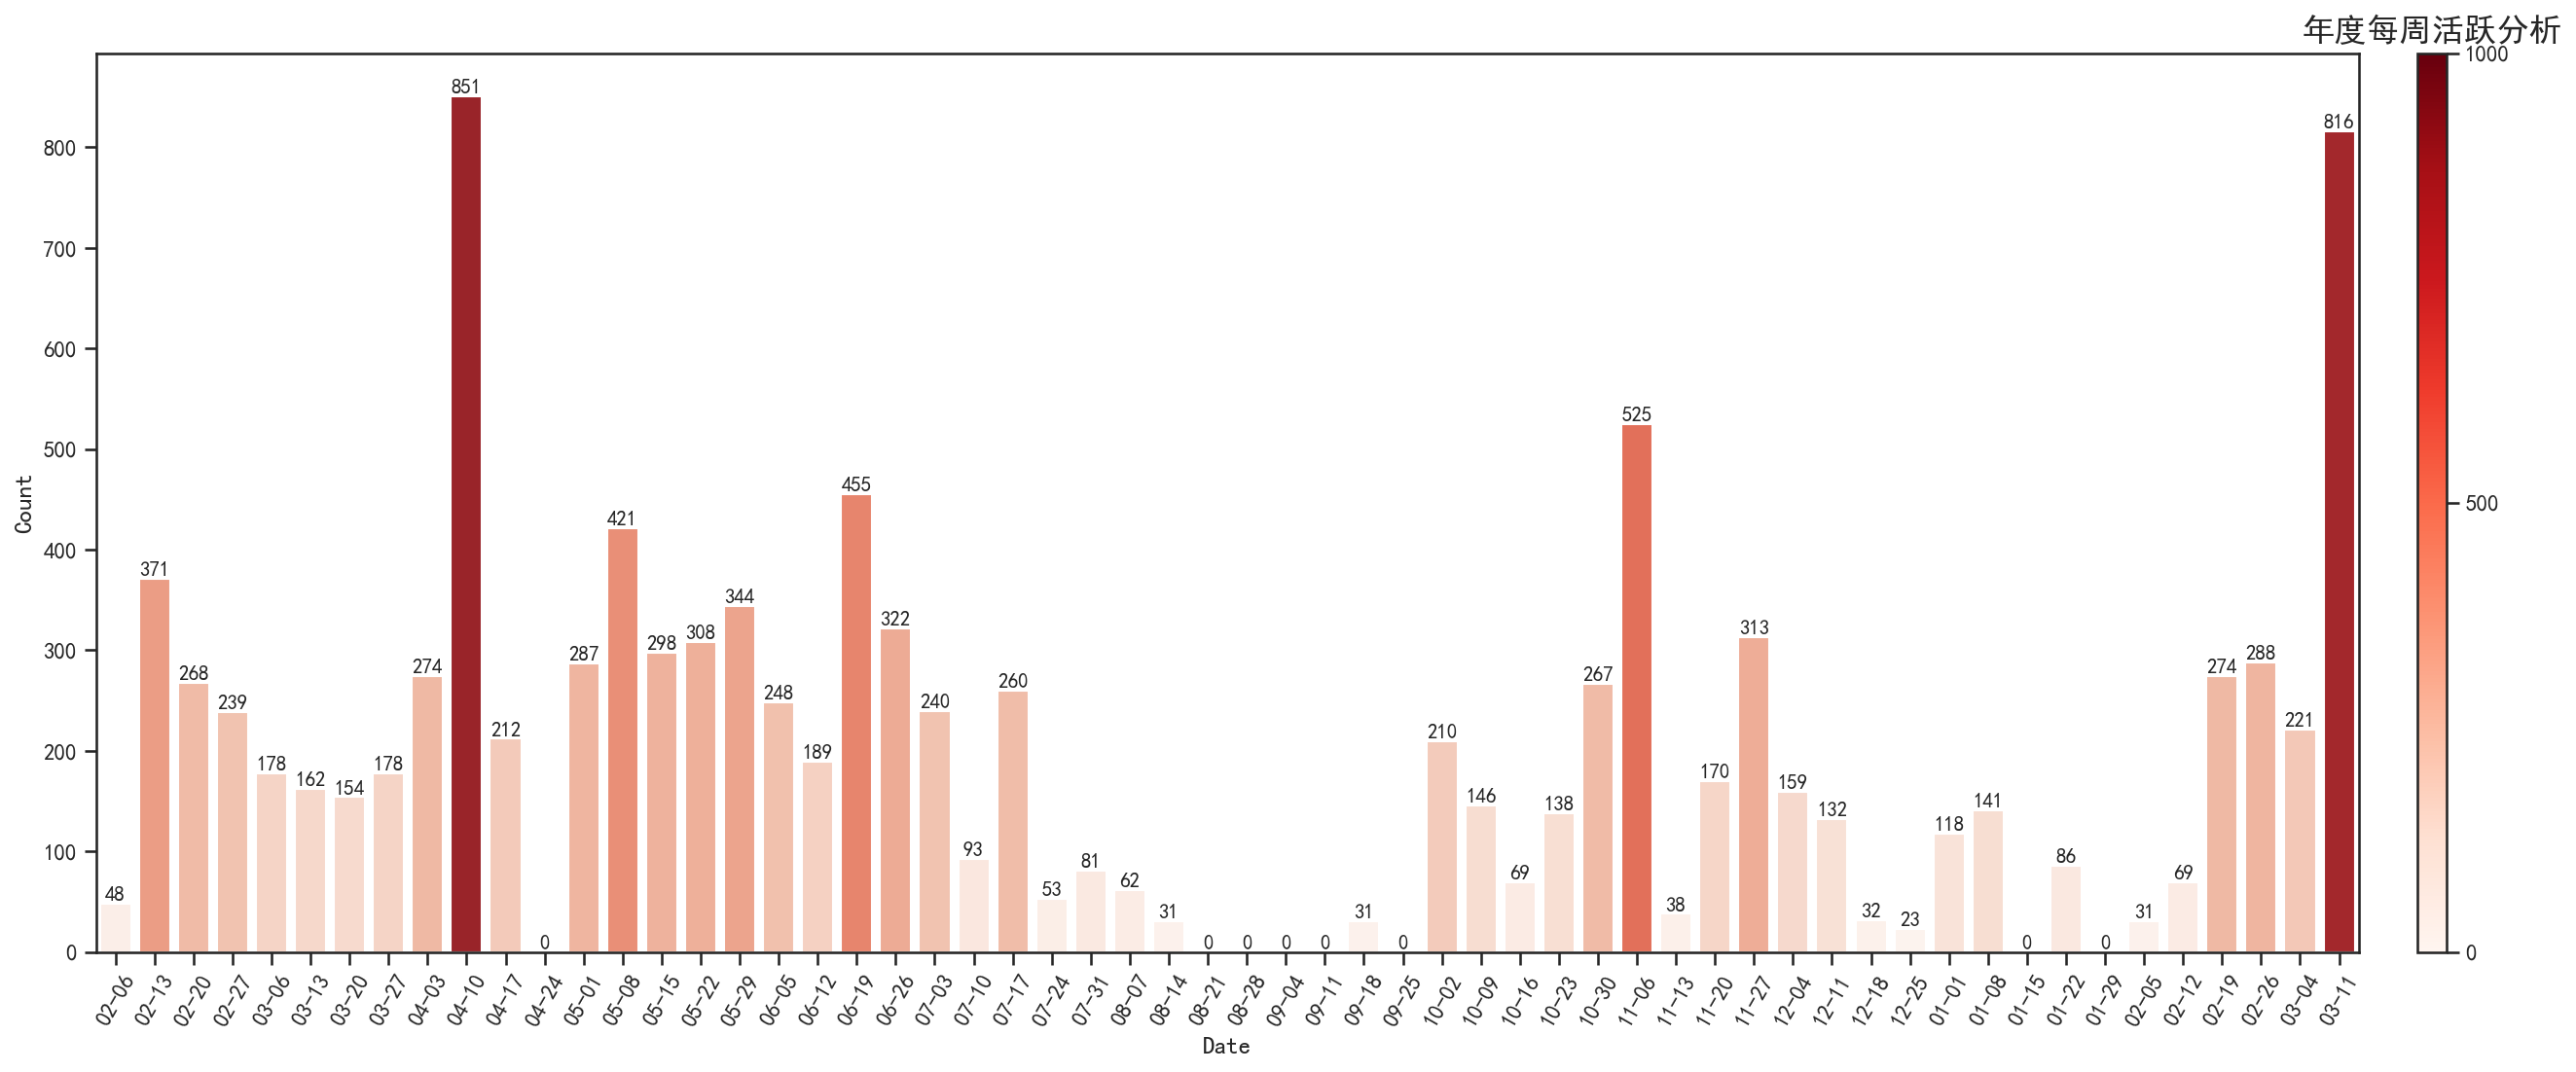

In [110]:
grouper = pd.Grouper(key="StrTime", freq="W-MON")
data = df.groupby(grouper)["Count"].sum().to_frame()
data.index = pd.date_range(start=wStart, end=wEnd, freq="W-MON").strftime("%m-%d")
data.columns = ["Count"]

vM = np.ceil(data["Count"].max() / wTicks) * wTicks
norm = plt.Normalize(0, vM)
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)

ax = sns.barplot(x=data.index, y=data["Count"], hue=data["Count"], hue_norm=norm, palette="Reds")
ax.set_xlabel("Date")
plt.xticks(rotation=60)
for bar in ax.containers:
    ax.bar_label(bar, fontsize=10, fmt="%.0f")
ax.get_legend().remove()

axpos = ax.get_position()
caxpos = mtransforms.Bbox.from_extents(axpos.x1 + 0.02, axpos.y0, axpos.x1 + 0.03, axpos.y1)
cax = ax.figure.add_axes(caxpos)

locator = mticker.MultipleLocator(wTicks)
formatter = mticker.StrMethodFormatter("{x:.0f}")
cax.figure.colorbar(sm, cax=cax, ticks=locator, format=formatter)

ax.figure.set_size_inches(20, 8)
ax.figure.set_dpi(150)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体
plt.title('年度每周活跃分析', fontsize=16)
plt.show()
plt.close()

### 按周划分聊天热情分析
划分每7天内的聊天热情指数，聊天热情指数为发送的消息数减去收到的消息数与总消息数的比值：
$$
E = \frac{Q_\mathrm{S} - Q_\mathrm{R}}{Q_\mathrm{S} + Q_\mathrm{R}}
$$

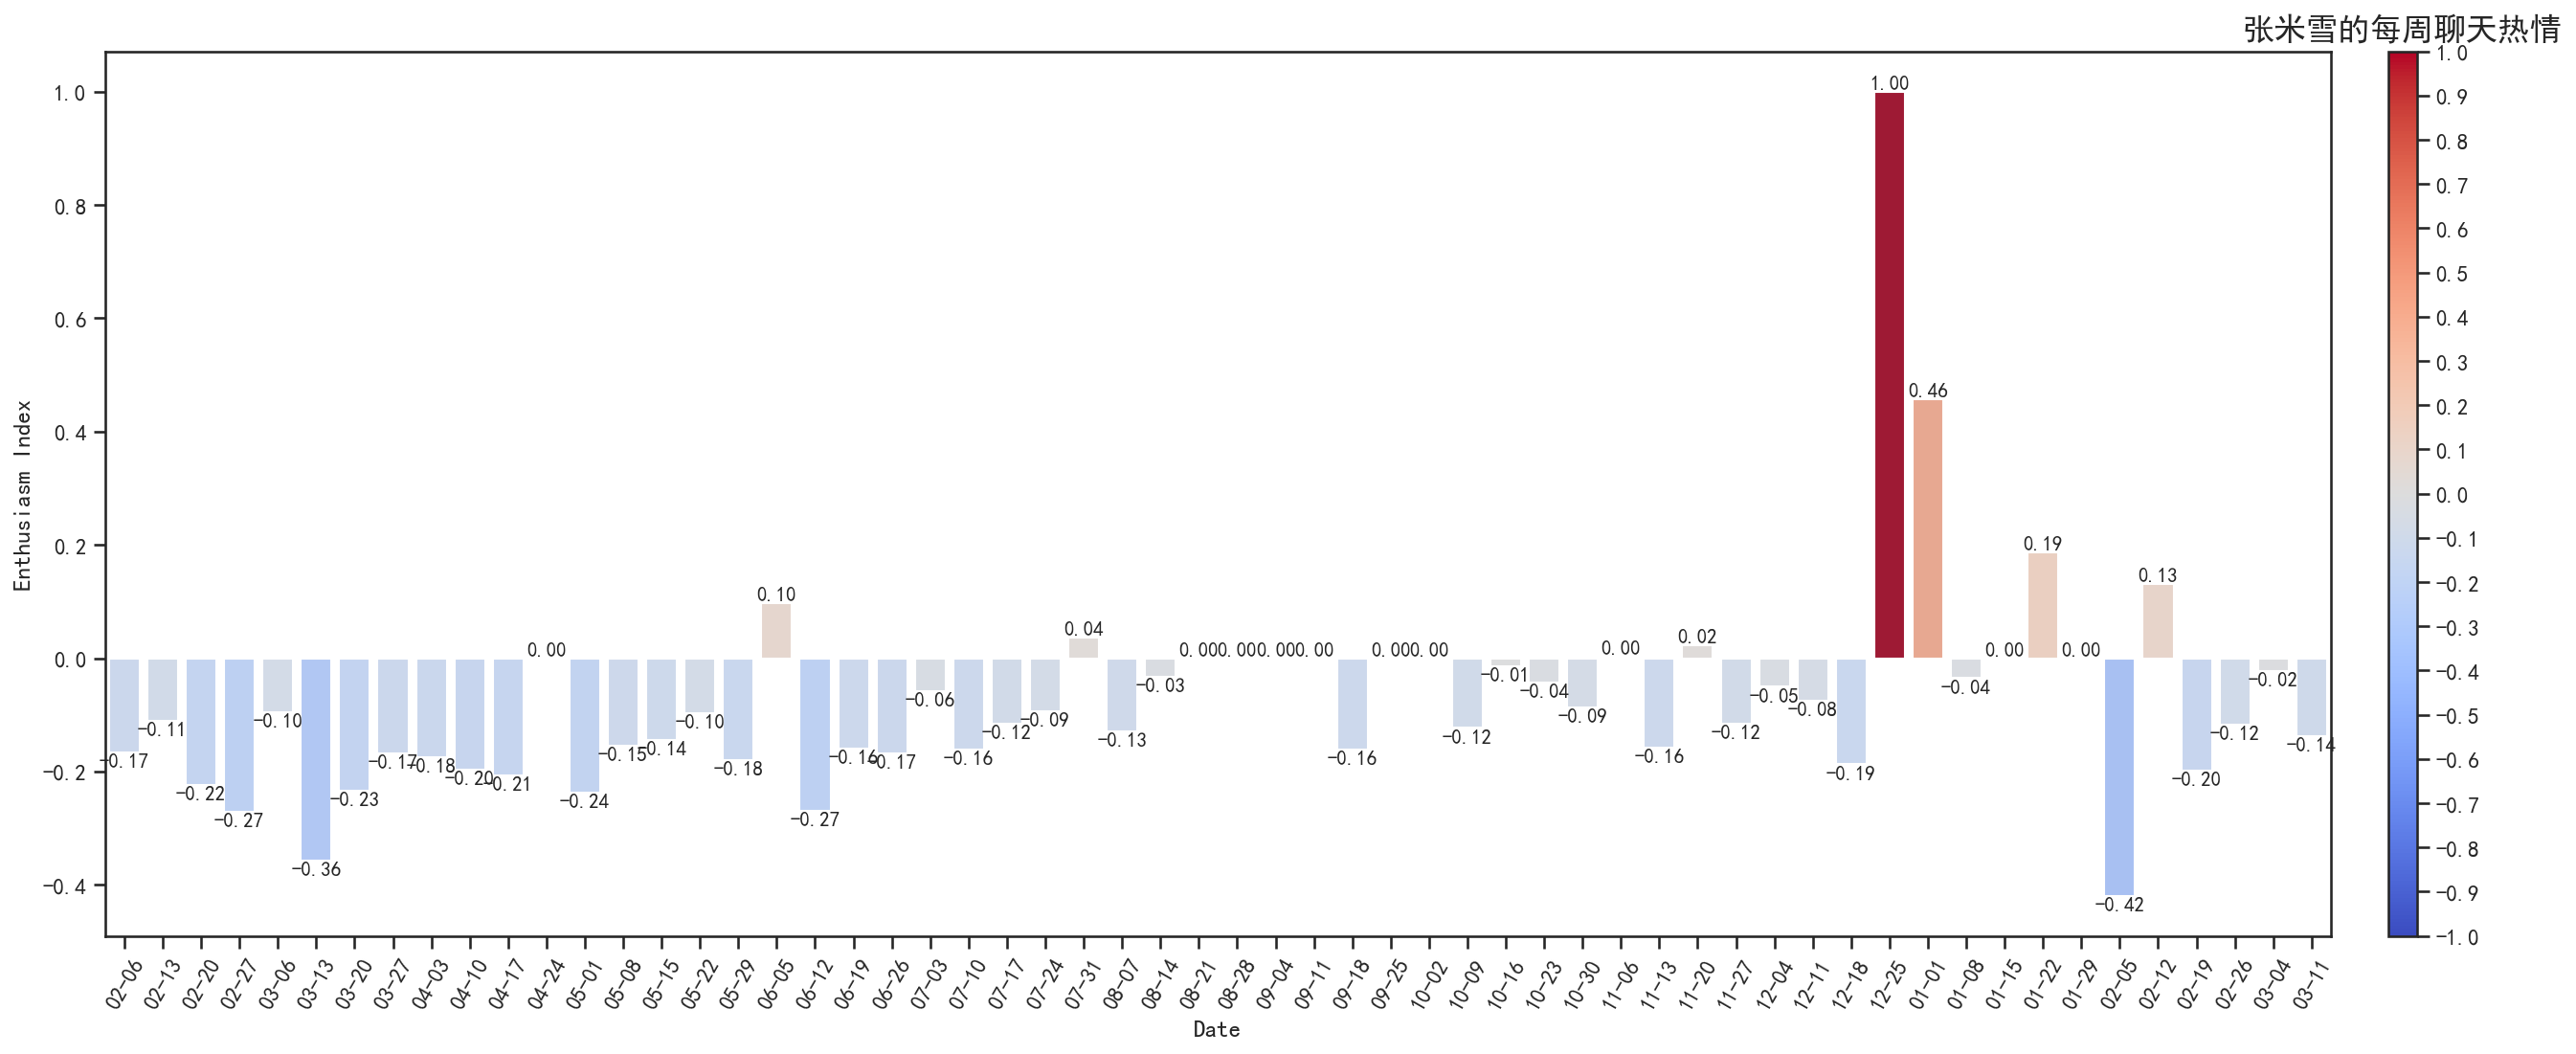

In [111]:
grouper = pd.Grouper(key="StrTime", freq="W-MON")
df_W1 = dfs[0].groupby(grouper)["Count"].sum()
df_W2 = dfs[1].groupby(grouper)["Count"].sum()

# 添加条件判断处理分母为零的情况
denominator = df_W1 + df_W2
data = pd.DataFrame({"E": np.where(denominator != 0, (df_W1 - df_W2) / denominator, 0)})
data.index = pd.date_range(start=wStart, end=wEnd, freq="W-MON").strftime("%m-%d")

vM = data["E"].abs().max()
norm = plt.Normalize(-vM, vM)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)

ax = sns.barplot(x=data.index, y=data["E"], hue=data["E"], hue_norm=norm, palette="coolwarm")
ax.set_xlabel("Date")
plt.xticks(rotation=60)
ax.set_ylabel("Enthusiasm Index")
for bar in ax.containers:
    ax.bar_label(bar, fontsize=10, fmt="%.2f")
ax.get_legend().remove()

axpos = ax.get_position()
caxpos = mtransforms.Bbox.from_extents(axpos.x1 + 0.02, axpos.y0, axpos.x1 + 0.03, axpos.y1)
cax = ax.figure.add_axes(caxpos)

locator = mticker.MultipleLocator(0.1)
formatter = mticker.StrMethodFormatter("{x:.1f}")
cax.figure.colorbar(sm, cax=cax, ticks=locator, format=formatter)

ax.figure.set_size_inches(20, 8)
ax.figure.set_dpi(150)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体
plt.title('友人A的每周聊天热情', fontsize=16)
plt.show()
plt.close()

### 按日划分年度活跃分析
以热力图的方式展示按日划分的年度活跃情况

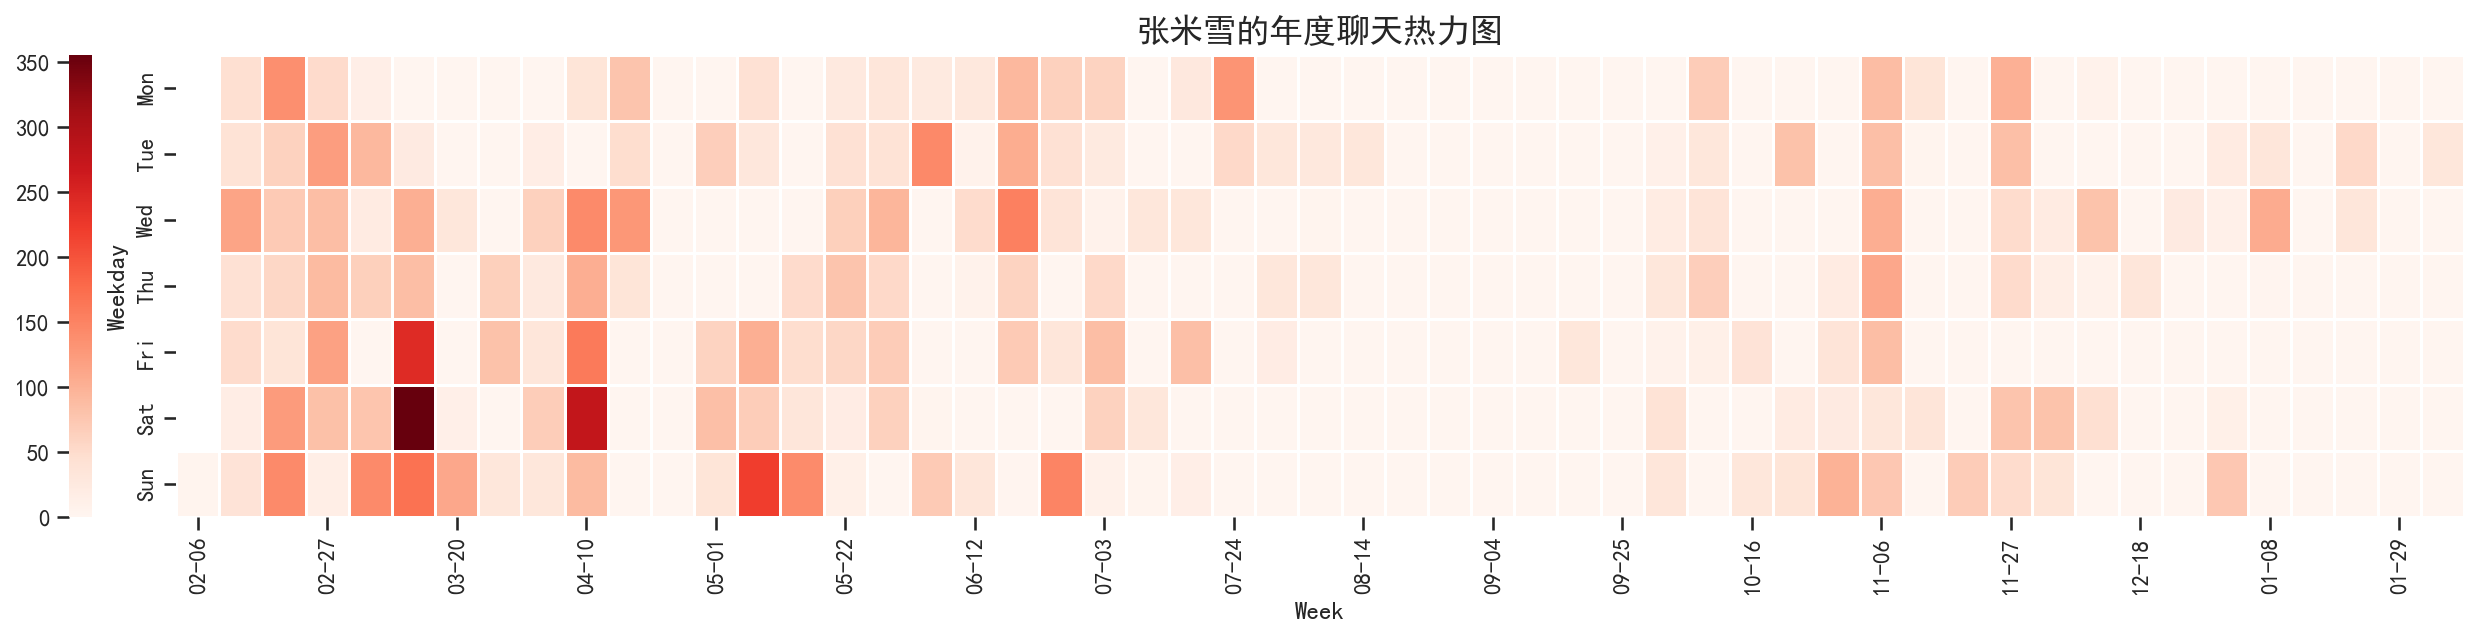

In [112]:
wTicks = 500
wStart = "2023-02-04"
wEnd = "2024-02-11"
##这里可能会报错元素数组有问题，没有关系多了就把上面的时间减一减，少了就加一点，凑够了就行
# grouper = pd.Grouper(key="StrTime", freq="W-MON")
# data = df.groupby(grouper)["Count"].sum().to_frame()
# data.index = pd.date_range(start=wStart, end=wEnd, freq="W-MON").strftime("%m-%d")
# data.columns = ["Count"]


grouper = pd.Grouper(key="StrTime", freq="D")
data = df.groupby(grouper)["Count"].sum()
data = data.to_frame()

data["date"] = data.index
data["week"] = data["date"].dt.isocalendar()["week"]
data["day"] = data["date"].dt.dayofweek
data.index = range(len(data))
for i in range(7):
    if data.loc[i, "week"] > 1:
        data.loc[i, "week"] = 0

# data = data.pivot(index="day", columns="week", values="Count")
# data.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
# data.columns = pd.date_range(start=wStart, end=wEnd, freq="W-MON").strftime("%m-%d")
data = data.pivot_table(index="day", columns="week", values="Count", aggfunc="sum")

# 重新设置索引和列
data.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
data.columns = pd.date_range(start=wStart, end=wEnd, freq="W-MON").strftime("%m-%d")

ax = sns.heatmap(
    data,
    annot=False,
    linewidths=0.5,
    cbar_kws={"orientation": "vertical", "location": "left", "pad": 0.03},
    cmap="Reds",
)
ax.set_xlabel("Week")
ax.set_ylabel("Weekday")
ax.figure.set_size_inches(24, 4)
ax.figure.set_dpi(150)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体
plt.title('友人A的年度聊天热力图', fontsize=16)
# Save the plot to the specified path
plt.savefig(r'C:\Users\admin\Documents\test\导出文件\imgs\7.png')
plt.show()
plt.close()

## 词语分析
### 分词词典、停止词与去除词性

In [113]:
jieba.load_userdict("thuocl.txt")
jieba.load_userdict("userdict.txt")
stopwords = [line.strip() for line in open("stopwords.txt", "r", encoding="utf-8").readlines()] + [" ", "\n", "\r\n"]
wordclass = ["v", "u", "vd", "r", "p", "w"]

### 分词函数

In [114]:
def wordSplit(texts, wordclass):
    words = []
    pbar = tqdm(total=len(texts))
    for i in range(len(texts)):
        res = pseg.lcut(texts[i])
        for pair in res:
            if pair.word in stopwords:
                continue
            if pair.flag in wordclass:
                continue
            words.append(pair.word)
        if i % 1000 == 0:
            pbar.update(1000)
    pbar.close()
    return words

In [115]:
words = [wordSplit(texts[i], wordclass) for i in range(2)]

4000it [00:02, 1545.00it/s]                          
4000it [00:03, 1188.61it/s]                          


### 词云绘制
* `font`: 字体路径，至少支持中文，最好同时支持中文和emoji
* `mask`: 词云的蒙版，影响词云的形状
* `cmap`: 色阶

In [116]:
font = "simsun.ttc"
mask = np.array(Image.open("mask.png"))
masks = [np.array(Image.open("mask_L.jpg")), np.array(Image.open("mask_F.jpg"))]
cmap = ListedColormap(
    [
        "#fac1cf",
        "#a9d7ba",
        "#58b1db",
        "#f296ab",
        "#5dab81",
        "#3d9ec4",
        "#e16a8d",
        "#237b50",
        "#1e8299",
        "#8d3549",
        "#35563b",
        "#2d5d73",
    ]
)

In [117]:
def wordCloud(text, font, mask, cmap):
    wc = WordCloud(
        background_color="white",
        scale=5,
        font_path=font,
        mask=mask,
        colormap=cmap,
        collocations=False,
    ).generate(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

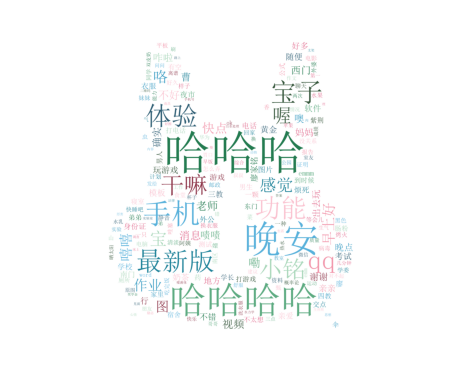

In [118]:
wordCloud(" ".join(words[0]), font, masks[0], cmap)

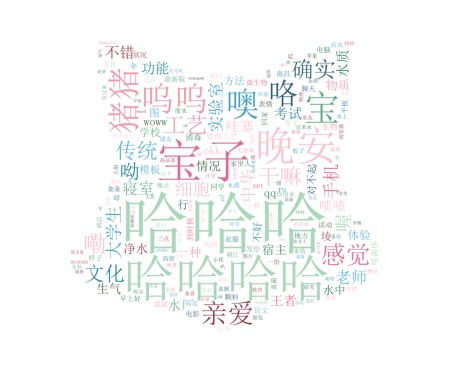

In [119]:
wordCloud(" ".join(words[1]), font, masks[1], cmap)

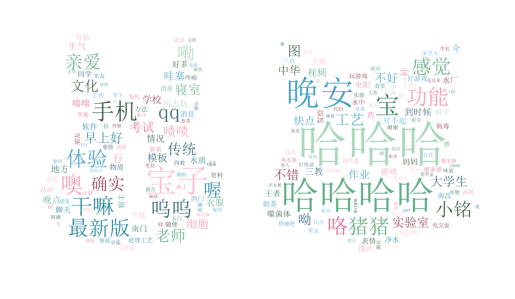

In [120]:
wordCloud(" ".join(words[0] + words[1]), font, mask, cmap)

### 高频词排行
列出常用的 N 个词，并且展示双方的贡献
* `wN`: 词的数目，默认为50

In [121]:
wN = 50

In [122]:
data = pd.DataFrame(
    {
        "words": words[0] + words[1],
        "L": [1] * len(words[0]) + [0] * len(words[1]),
        "F": [0] * len(words[0]) + [1] * len(words[1]),
        "S": [1] * len(words[0]) + [1] * len(words[1]),
    }
)

grouper = pd.Grouper(key="words")
data = data.groupby(grouper).sum()
data = data.sort_values(by="S", ascending=False)
data = data.iloc[:wN]

In [123]:
# 将部分无法识别的 emoji 转化为文字
tmp = data.index.to_list()
for i in range(wN):
    if tmp[i] == "😘":
        tmp[i] = "[亲亲]"
    elif tmp[i] == "😂":
        tmp[i] = "[笑哭]"
    elif tmp[i] == "🤦":
        tmp[i] = "[捂脸]"
    elif tmp[i] == "😁":
        tmp[i] = "[呲牙]"
data.index = tmp

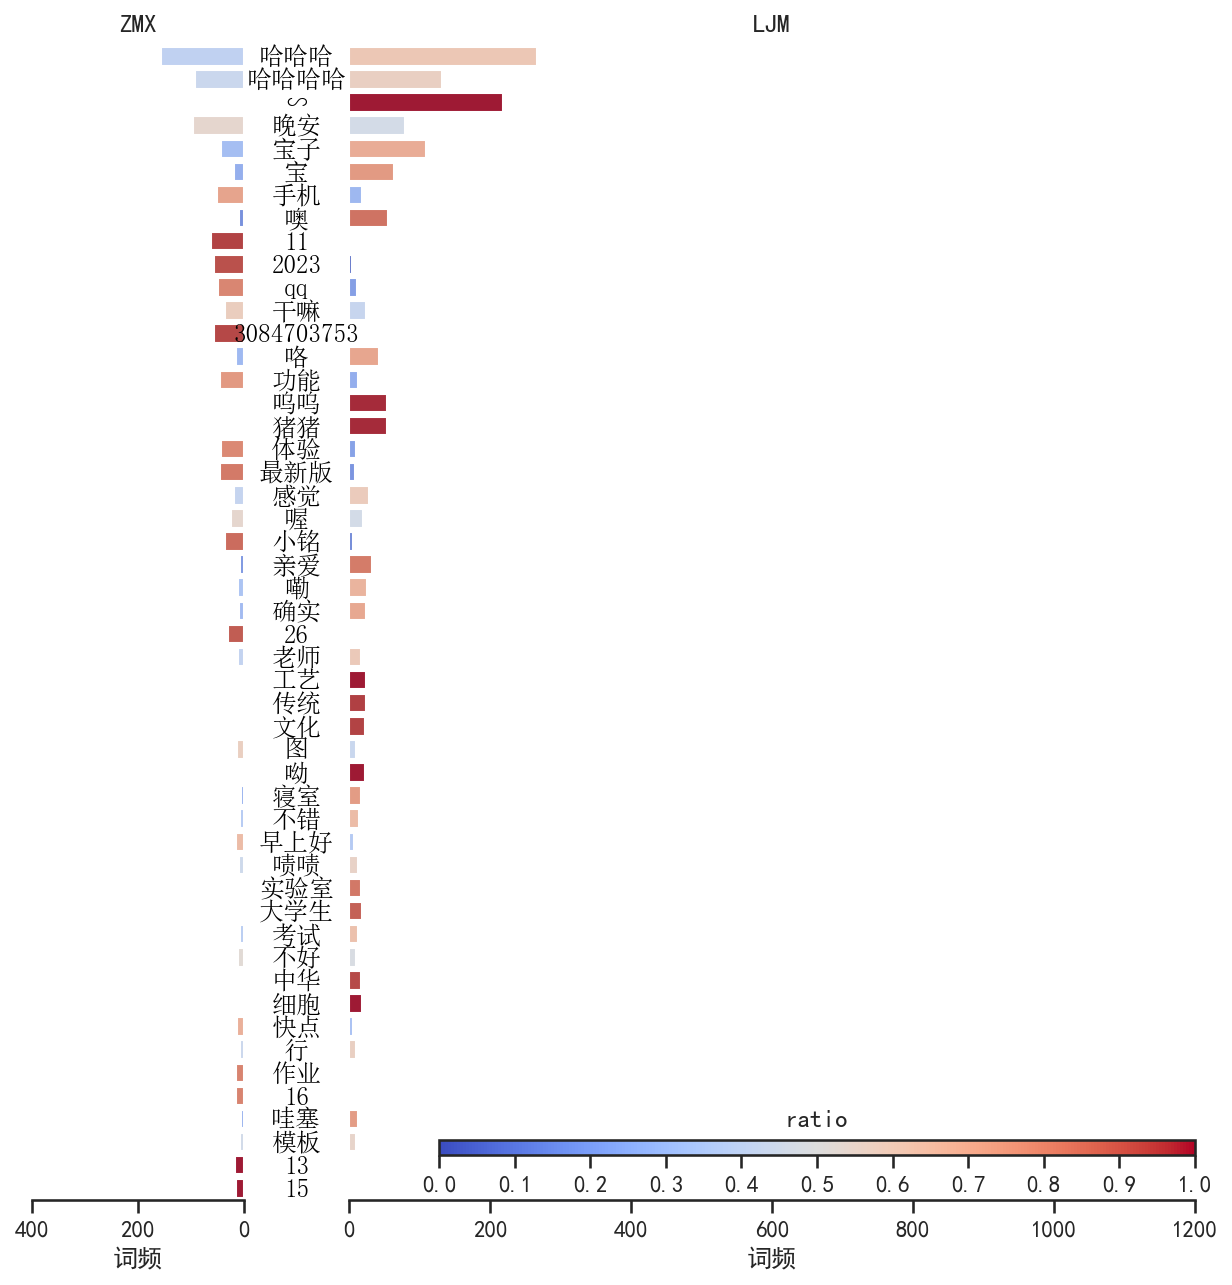

In [124]:
ratio = data["L"] / data["S"]
norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)

fig = plt.figure(figsize=(10, 10), dpi=300)
grid = plt.GridSpec(1, 4, wspace=0.5)

ax0 = fig.add_subplot(grid[0, 0])
sns.barplot(x=-data["L"], y=data.index, ax=ax0, hue=ratio, hue_norm=norm, palette="coolwarm")
ax1 = fig.add_subplot(grid[0, 1:])
sns.barplot(x=data["F"], y=data.index, ax=ax1, hue=(1 - ratio), hue_norm=norm, palette="coolwarm")

ax0.set_xlabel("词频")
ax0.set_ylabel("")
ax0.set_xticks(range(-400, 1, 200))
ax0.set_xticklabels([400, 200, 0])
ax0.set_xlim(-400, 0)
ax0.set_yticks([])
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.set_title("ZMX")
ax0.get_legend().remove()

ax1.set_xlabel("词频")
ax1.set_ylabel("")
ax1.set_xticks(range(0, 1201, 200))
ax1.set_xticklabels([0, 200, 400, 600, 800, 1000, 1200])
ax1.set_xlim(0, 1200)
ax1.set_yticks([])
ax1.spines["left"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_title("LJM")
ax1.get_legend().remove()

axpos = ax1.get_position()
caxpos = mtransforms.Bbox.from_extents(axpos.x0 + 0.06, axpos.y0 + 0.03, axpos.x1, axpos.y0 + 0.04)
cax = ax1.figure.add_axes(caxpos)

locator = mticker.MultipleLocator(0.1)
formatter = mticker.StrMethodFormatter("{x:.1f}")
cax.figure.colorbar(sm, cax=cax, orientation="horizontal", ticks=locator, format=formatter)
# cax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
cax.set_title("ratio")

x0 = ax0.get_position().x1
x1 = ax1.get_position().x0
xm = (x0 + x1) / 2
y0 = ax0.get_position().y0
y1 = ax0.get_position().y1

for i in range(wN):
    fig.text(
        xm, y0 + (y1 - y0) * (wN - i - 0.5) / wN, data.index[i],
        color="black", ha="center", va="center", fontproperties=fp
    )

fig.set_dpi(150)
plt.savefig(r'C:\Users\admin\Documents\test\导出文件\imgs\8.png')
plt.show()
plt.close()

## 情感分析
使用 `paddlenlp` 进行情感分析，得到的分数在 [-1, 1] 之间，越小越消极，越大越积极

In [125]:
dfE = df.query("Type == 1")[["IsSender", "StrContent", "StrTime", "hour"]]
dfE.index = range(len(dfE))

In [126]:
senta = Taskflow("sentiment_analysis")

In [127]:
scores = pd.DataFrame(senta([textFilter(i) for i in dfE["StrContent"].to_list()]))
scores.loc[scores["label"] == "negative", "score"] = 1 - scores.loc[scores["label"] == "negative", "score"]

In [128]:
dfE["score"] = scores["score"]
dfE["score"] = 2 * dfE["score"] - 1
dfE["Person"] = dfE.apply(lambda x: labels[int(x["IsSender"]) if pd.notna(x["IsSender"]) else -1], axis=1)
dfEs = [dfE.query("IsSender == 0"), dfE.query("IsSender == 1")]


### 年度总体情感分布

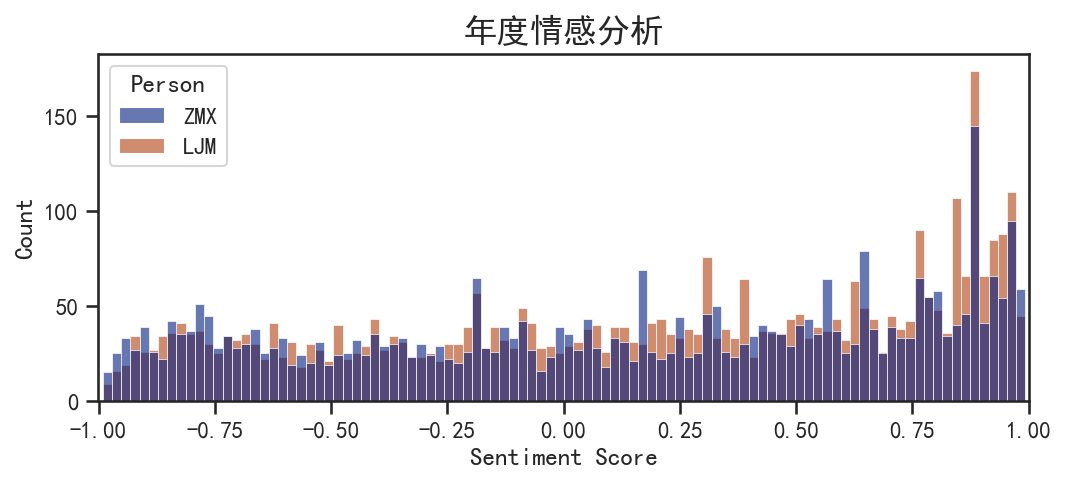

In [129]:
ax = sns.histplot(data=dfE, x="score", hue="Person", palette="dark", alpha=0.6, bins=100)

ax.set_xlabel("Sentiment Score")
ax.set_ylabel("Count")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体
plt.title('年度情感分析', fontsize=16)
ax.set_xlim(-1, 1)

ax.figure.set_size_inches(8, 3)
ax.figure.set_dpi(150)
plt.savefig(r'C:\Users\admin\Documents\test\导出文件\imgs\9.png')
plt.show()

### 按周统计平均情感指数

In [130]:
def weekAvgSenScore(df):
    grouper = pd.Grouper(key="StrTime", freq="W-MON")
    data = df.groupby(grouper)["score"].mean().to_frame()
    data.index = pd.date_range(start=wStart, end=wEnd, freq="W-MON").strftime("%m-%d")
    data.columns = ["score"]
    # 将 "score" 列中的 NaN 值替换为 0
    data["score"].fillna(0, inplace=True)

    vM = data["score"].abs().max()
    norm = plt.Normalize(-vM, vM)
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)

    ax = sns.barplot(x=data.index, y=data["score"], hue=data["score"], hue_norm=norm, palette="coolwarm")
    ax.set_xlabel("Date")
    plt.xticks(rotation=60)
    for bar in ax.containers:
        ax.bar_label(bar, fontsize=10, fmt="%.2f")
    ax.get_legend().remove()

    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(axpos.x1 + 0.02, axpos.y0, axpos.x1 + 0.03, axpos.y1)
    cax = ax.figure.add_axes(caxpos)

    locator = mticker.MultipleLocator(0.05)
    formatter = mticker.StrMethodFormatter("{x:.2f}")
    cax.figure.colorbar(sm, cax=cax, ticks=locator, format=formatter)

    ax.figure.set_size_inches(20, 8)
    ax.figure.set_dpi(150)
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体
    plt.title('平均情感指数', fontsize=16)  
    plt.savefig(r'C:\Users\admin\Documents\test\导出文件\imgs\10.png')
    plt.show()
    plt.close()

    return data["score"]

C:\Users\admin\AppData\Local\Temp\ipykernel_244\2114938416.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["score"].fillna(0, inplace=True)


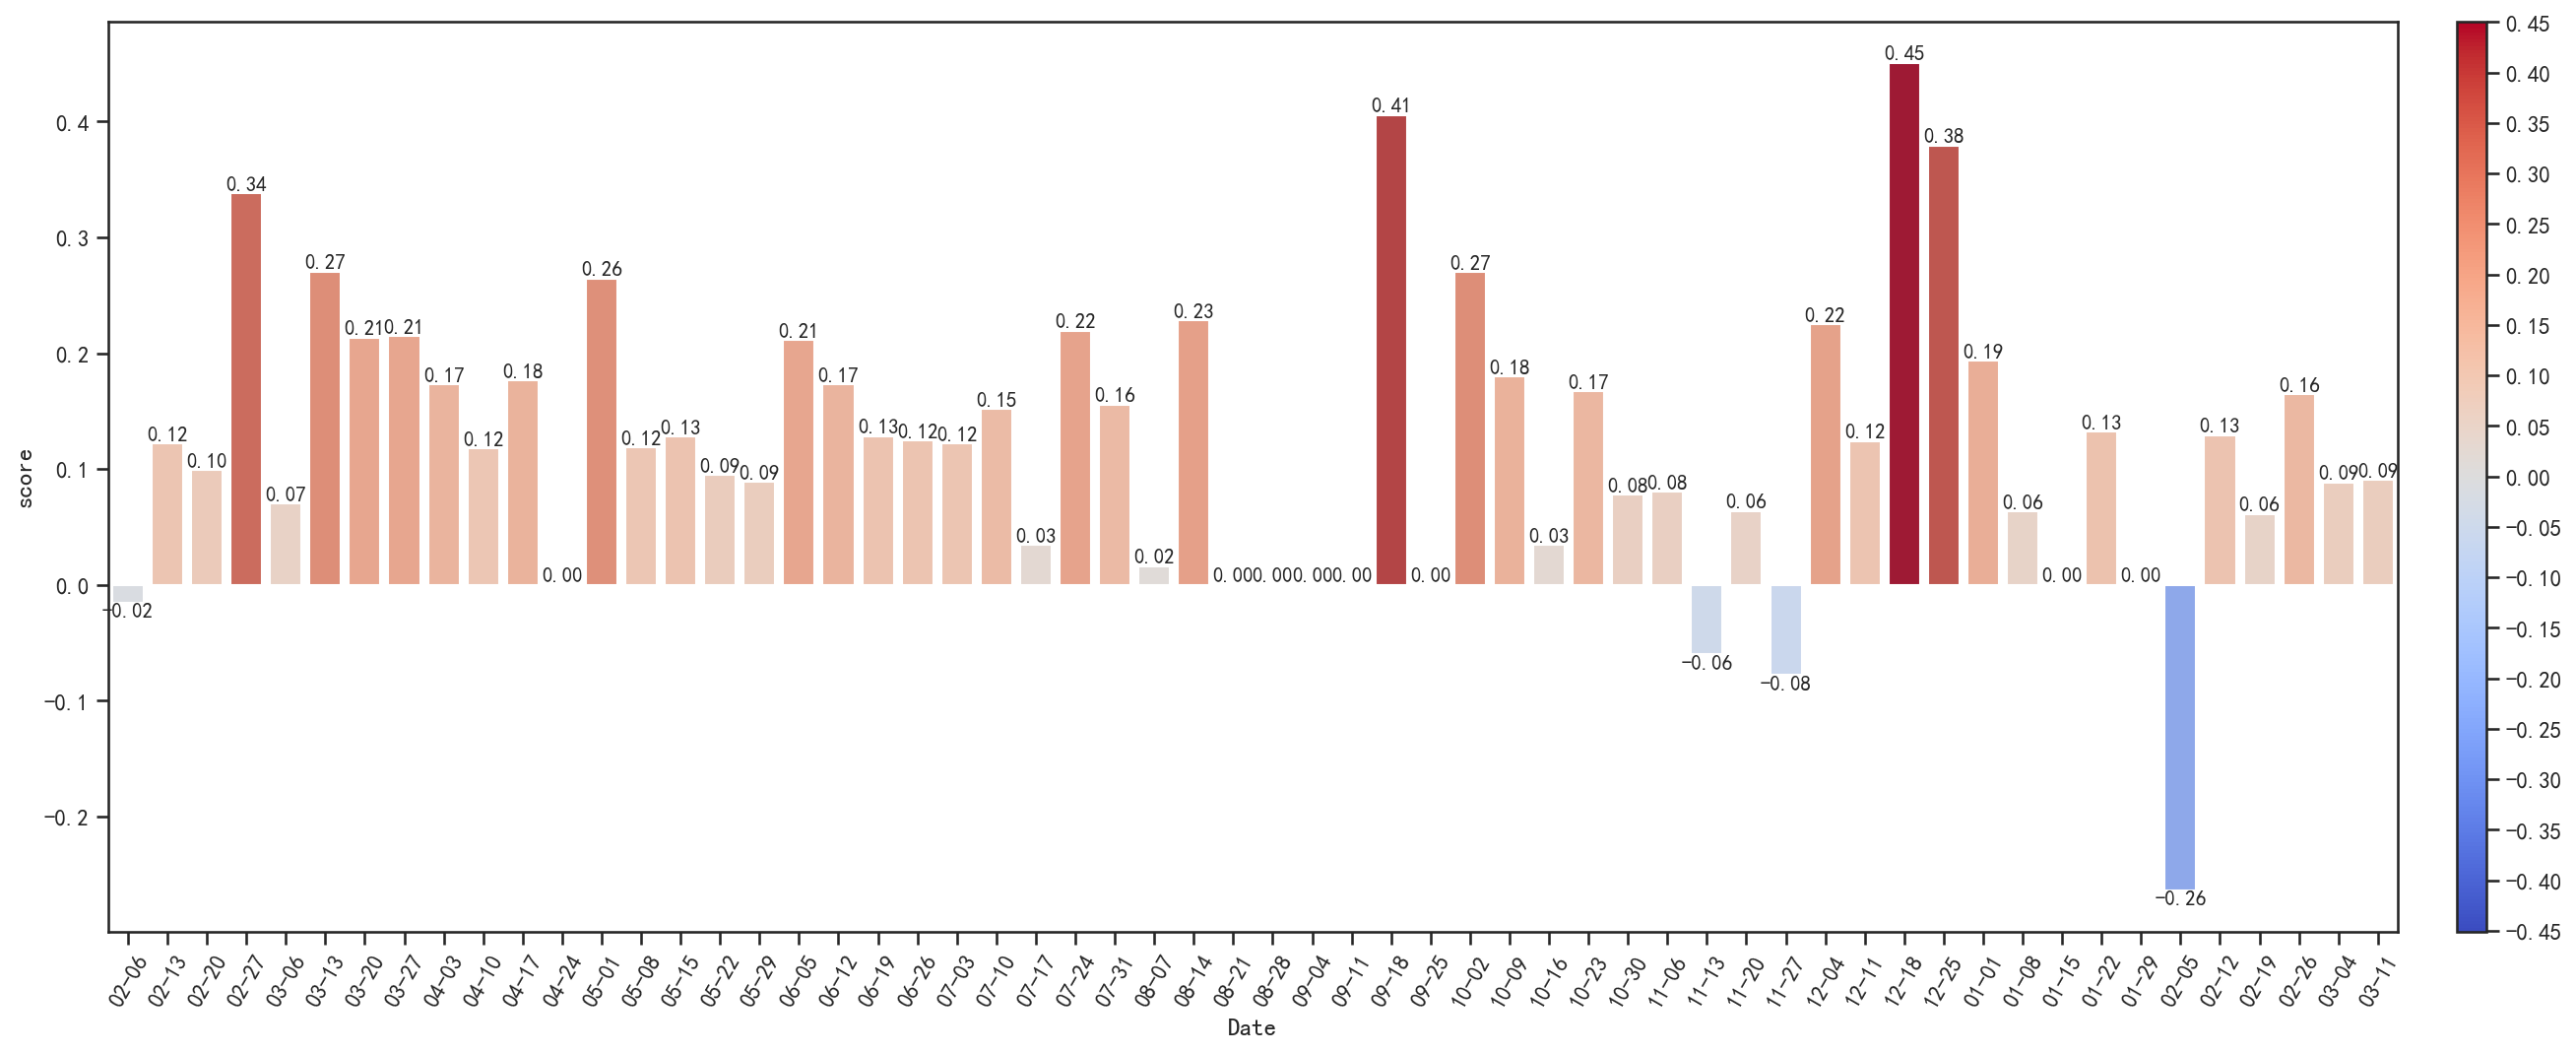

In [76]:
wTicks = 500
wStart = "2023-02-04"
wEnd = "2024-03-11"
avgSenScore0 = weekAvgSenScore(dfEs[0])

C:\Users\admin\AppData\Local\Temp\ipykernel_244\628266265.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["score"].fillna(0, inplace=True)


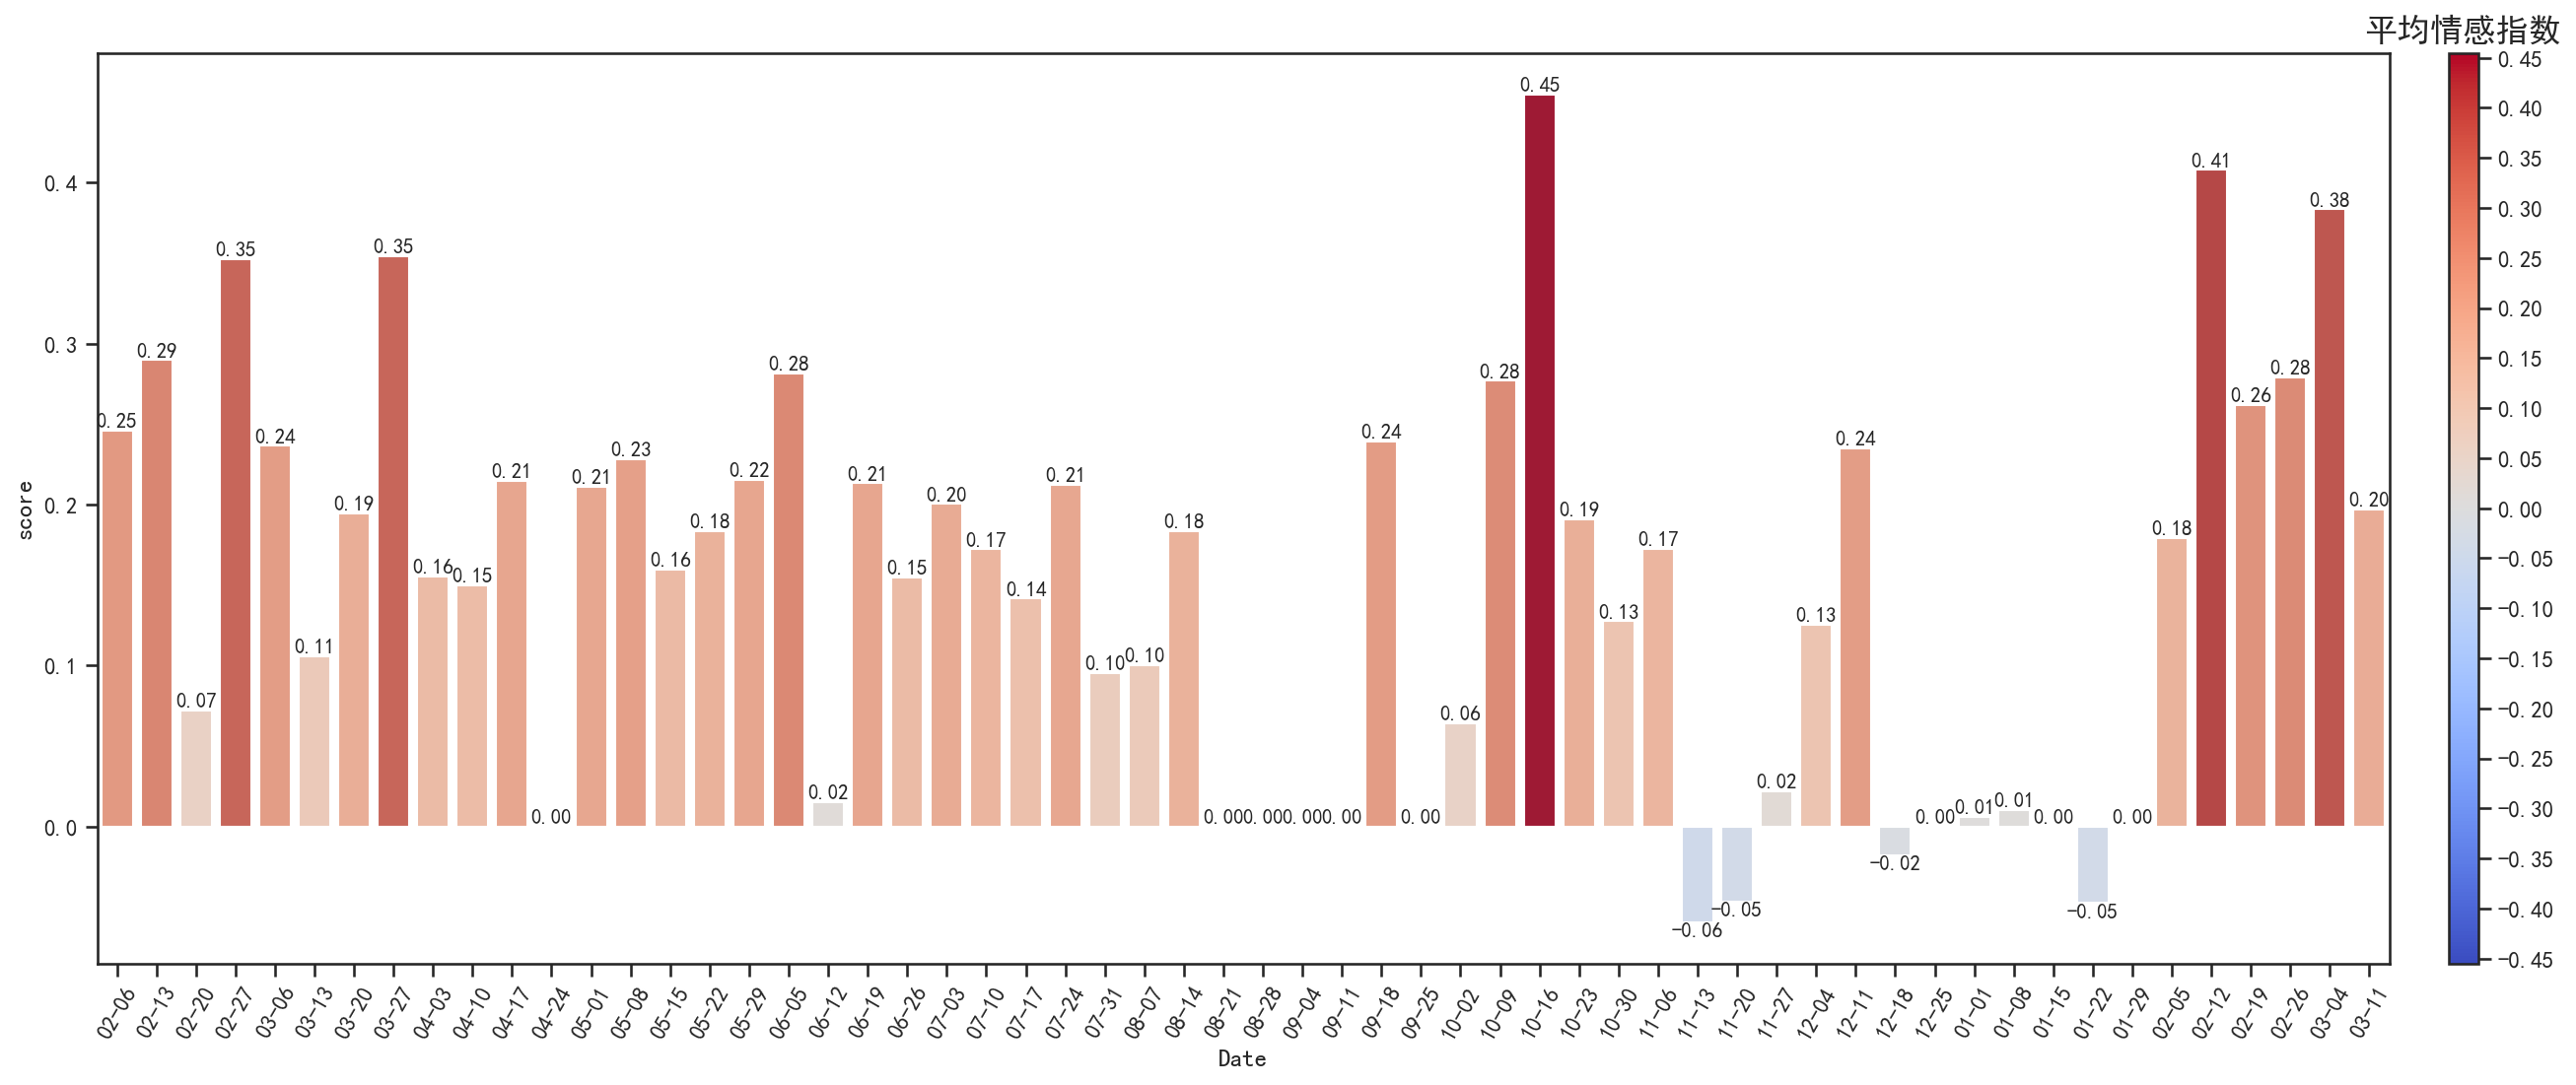

In [78]:
avgSenScore1 = weekAvgSenScore(dfEs[1])

C:\Users\admin\AppData\Local\Temp\ipykernel_244\628266265.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["score"].fillna(0, inplace=True)


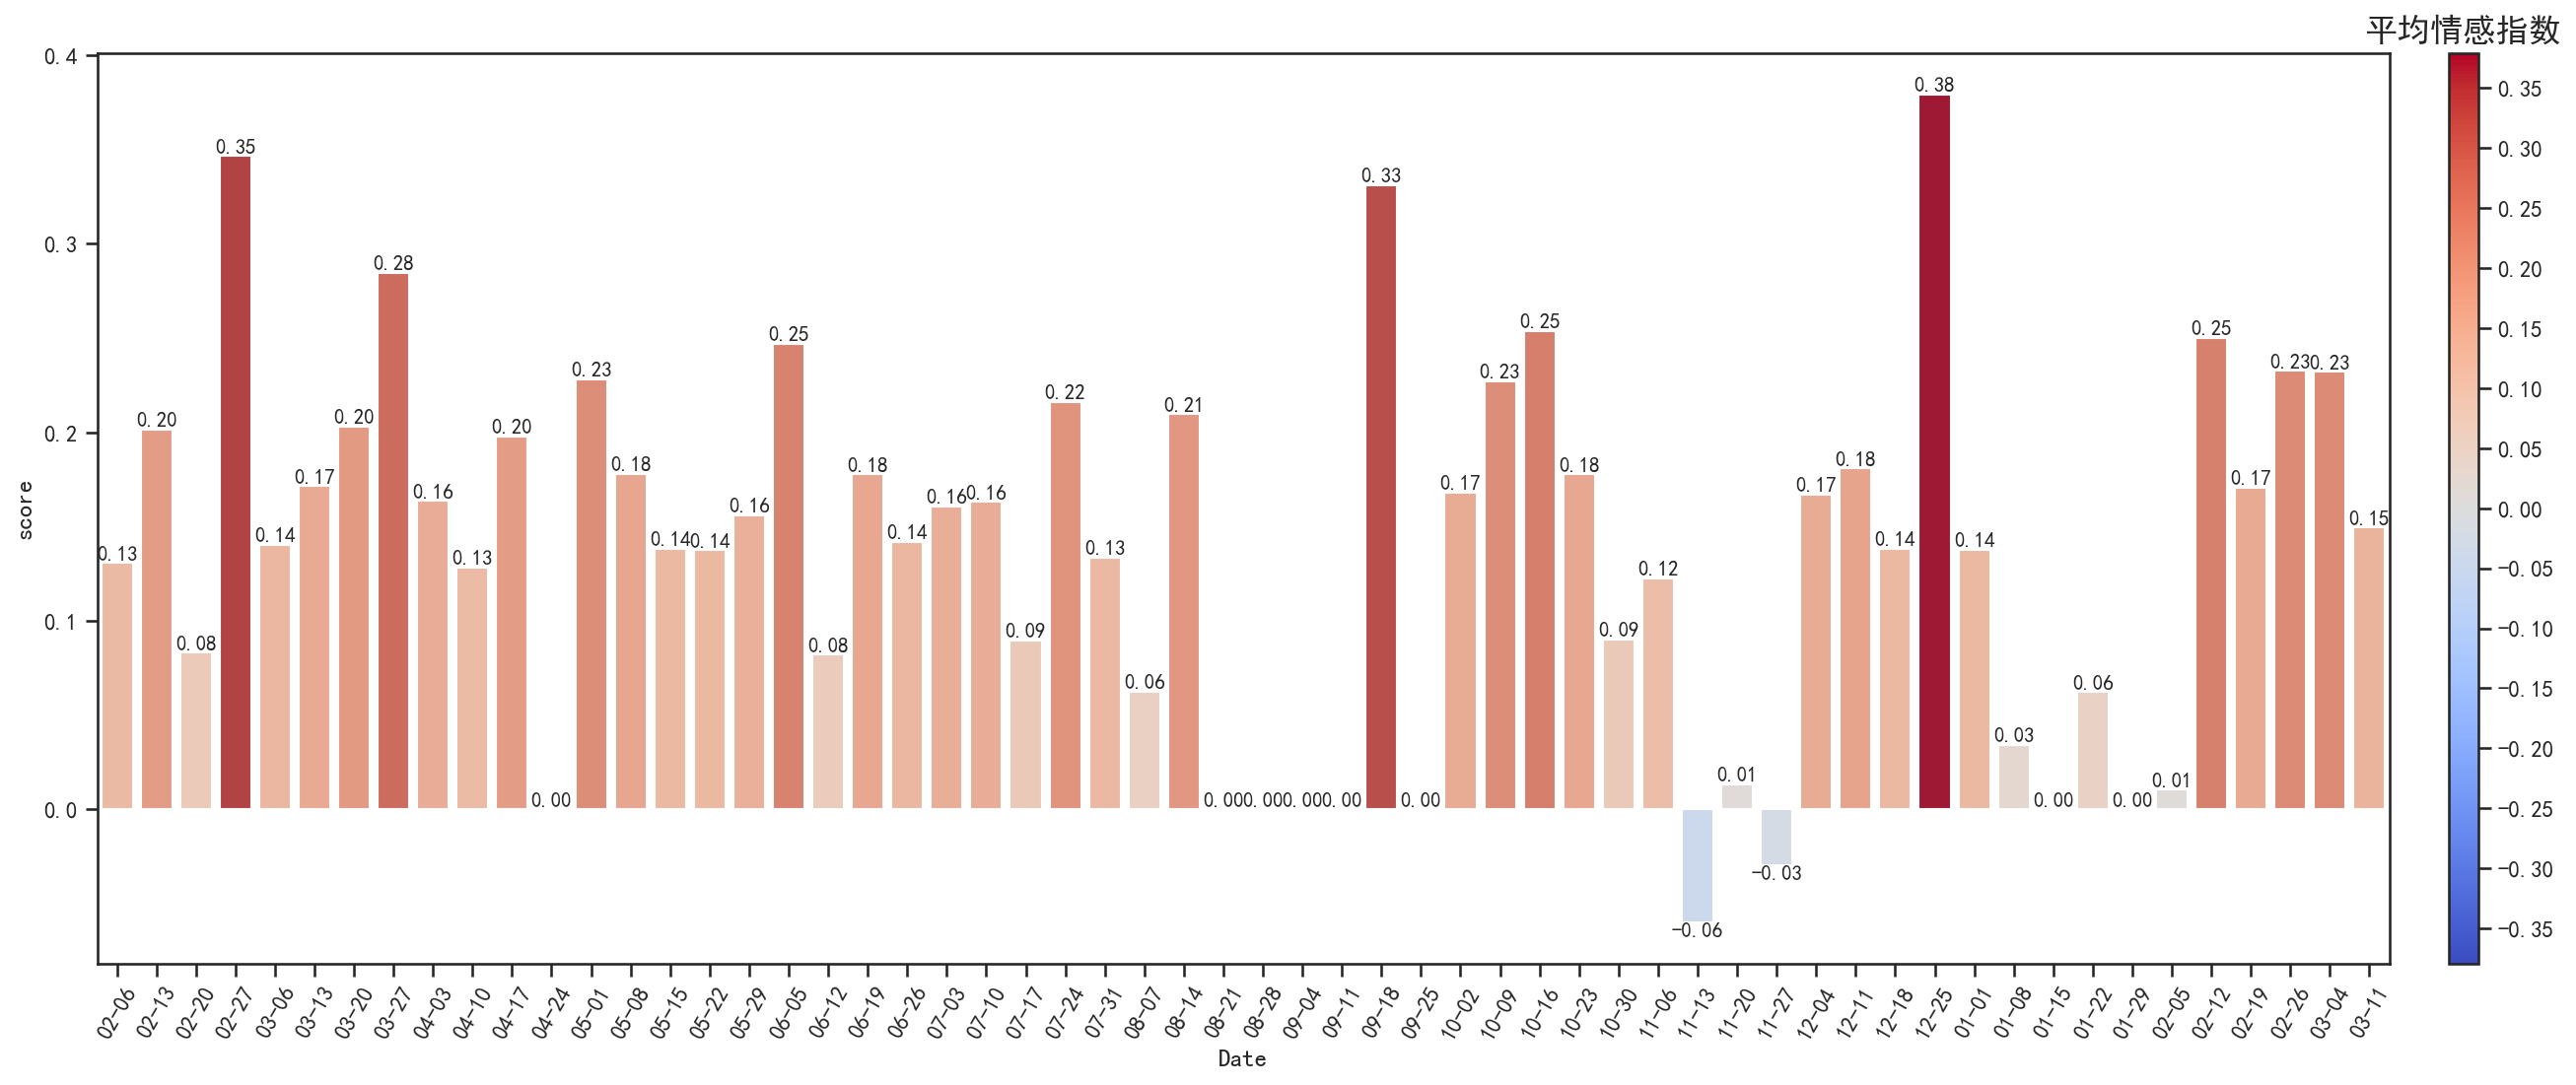

In [79]:
_ = weekAvgSenScore(dfE)

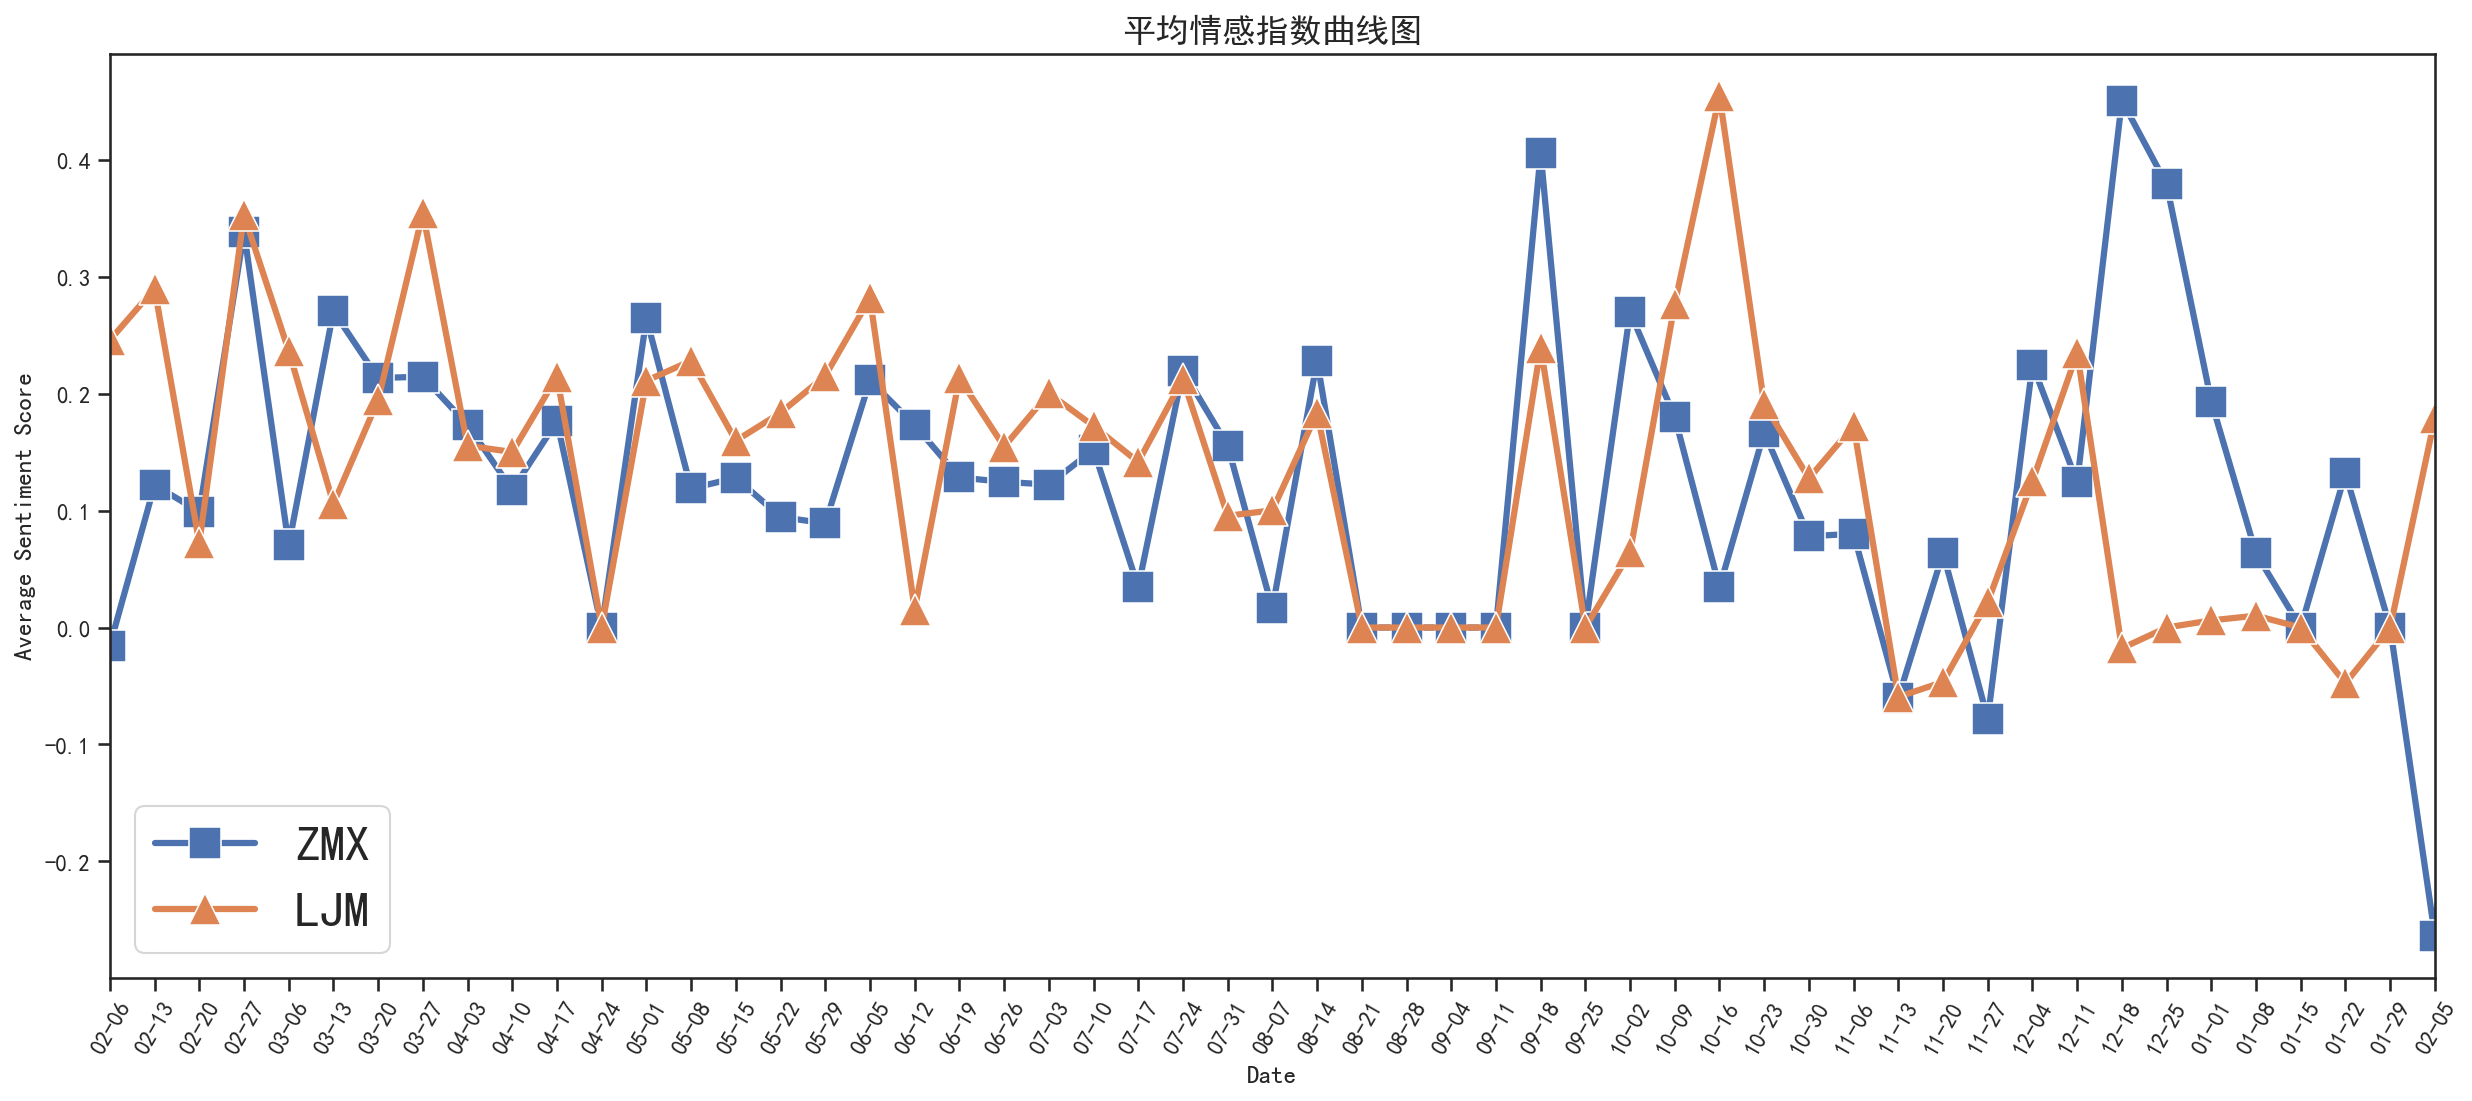

In [131]:
ax = sns.lineplot(data=avgSenScore0, linewidth=3, marker="s", markersize=15, label=labels[0])
ax = sns.lineplot(data=avgSenScore1, linewidth=3, marker="^", markersize=15, ax=ax, label=labels[1])

ax.set_xlabel("Date")
plt.xticks(rotation=60)
ax.set_ylabel("Average Sentiment Score")
ax.set_xlim(0, 52)
ax.legend(prop={"size": 24})

ax.figure.set_size_inches(20, 8)
ax.figure.set_dpi(150)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体
plt.title('平均情感指数曲线图', fontsize=16)  
plt.savefig(r'C:\Users\admin\Documents\test\导出文件\imgs\11.png')
plt.show()
plt.close()

### 按周统计累计情感指数

In [82]:
def weekTotSenScore(df):
    grouper = pd.Grouper(key="StrTime", freq="W-MON")
    data = df.groupby(grouper)["score"].sum().to_frame()
    data.index = pd.date_range(start=wStart, end=wEnd, freq="W-MON").strftime("%m-%d")
    data.columns = ["score"]

    vM = data["score"].abs().max()
    norm = plt.Normalize(-vM, vM)
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)

    ax = sns.barplot(x=data.index, y=data["score"], hue=data["score"], hue_norm=norm, palette="coolwarm")
    ax.set_xlabel("Date")
    plt.xticks(rotation=60)
    for bar in ax.containers:
        ax.bar_label(bar, fontsize=10, fmt="%.2f")
    ax.get_legend().remove()

    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(axpos.x1 + 0.02, axpos.y0, axpos.x1 + 0.03, axpos.y1)
    cax = ax.figure.add_axes(caxpos)

    locator = mticker.MultipleLocator(20)
    formatter = mticker.StrMethodFormatter("{x:.2f}")
    cax.figure.colorbar(sm, cax=cax, ticks=locator, format=formatter)

    ax.figure.set_size_inches(20, 8)
    ax.figure.set_dpi(150)
    plt.show()
    plt.close()

    return data["score"]

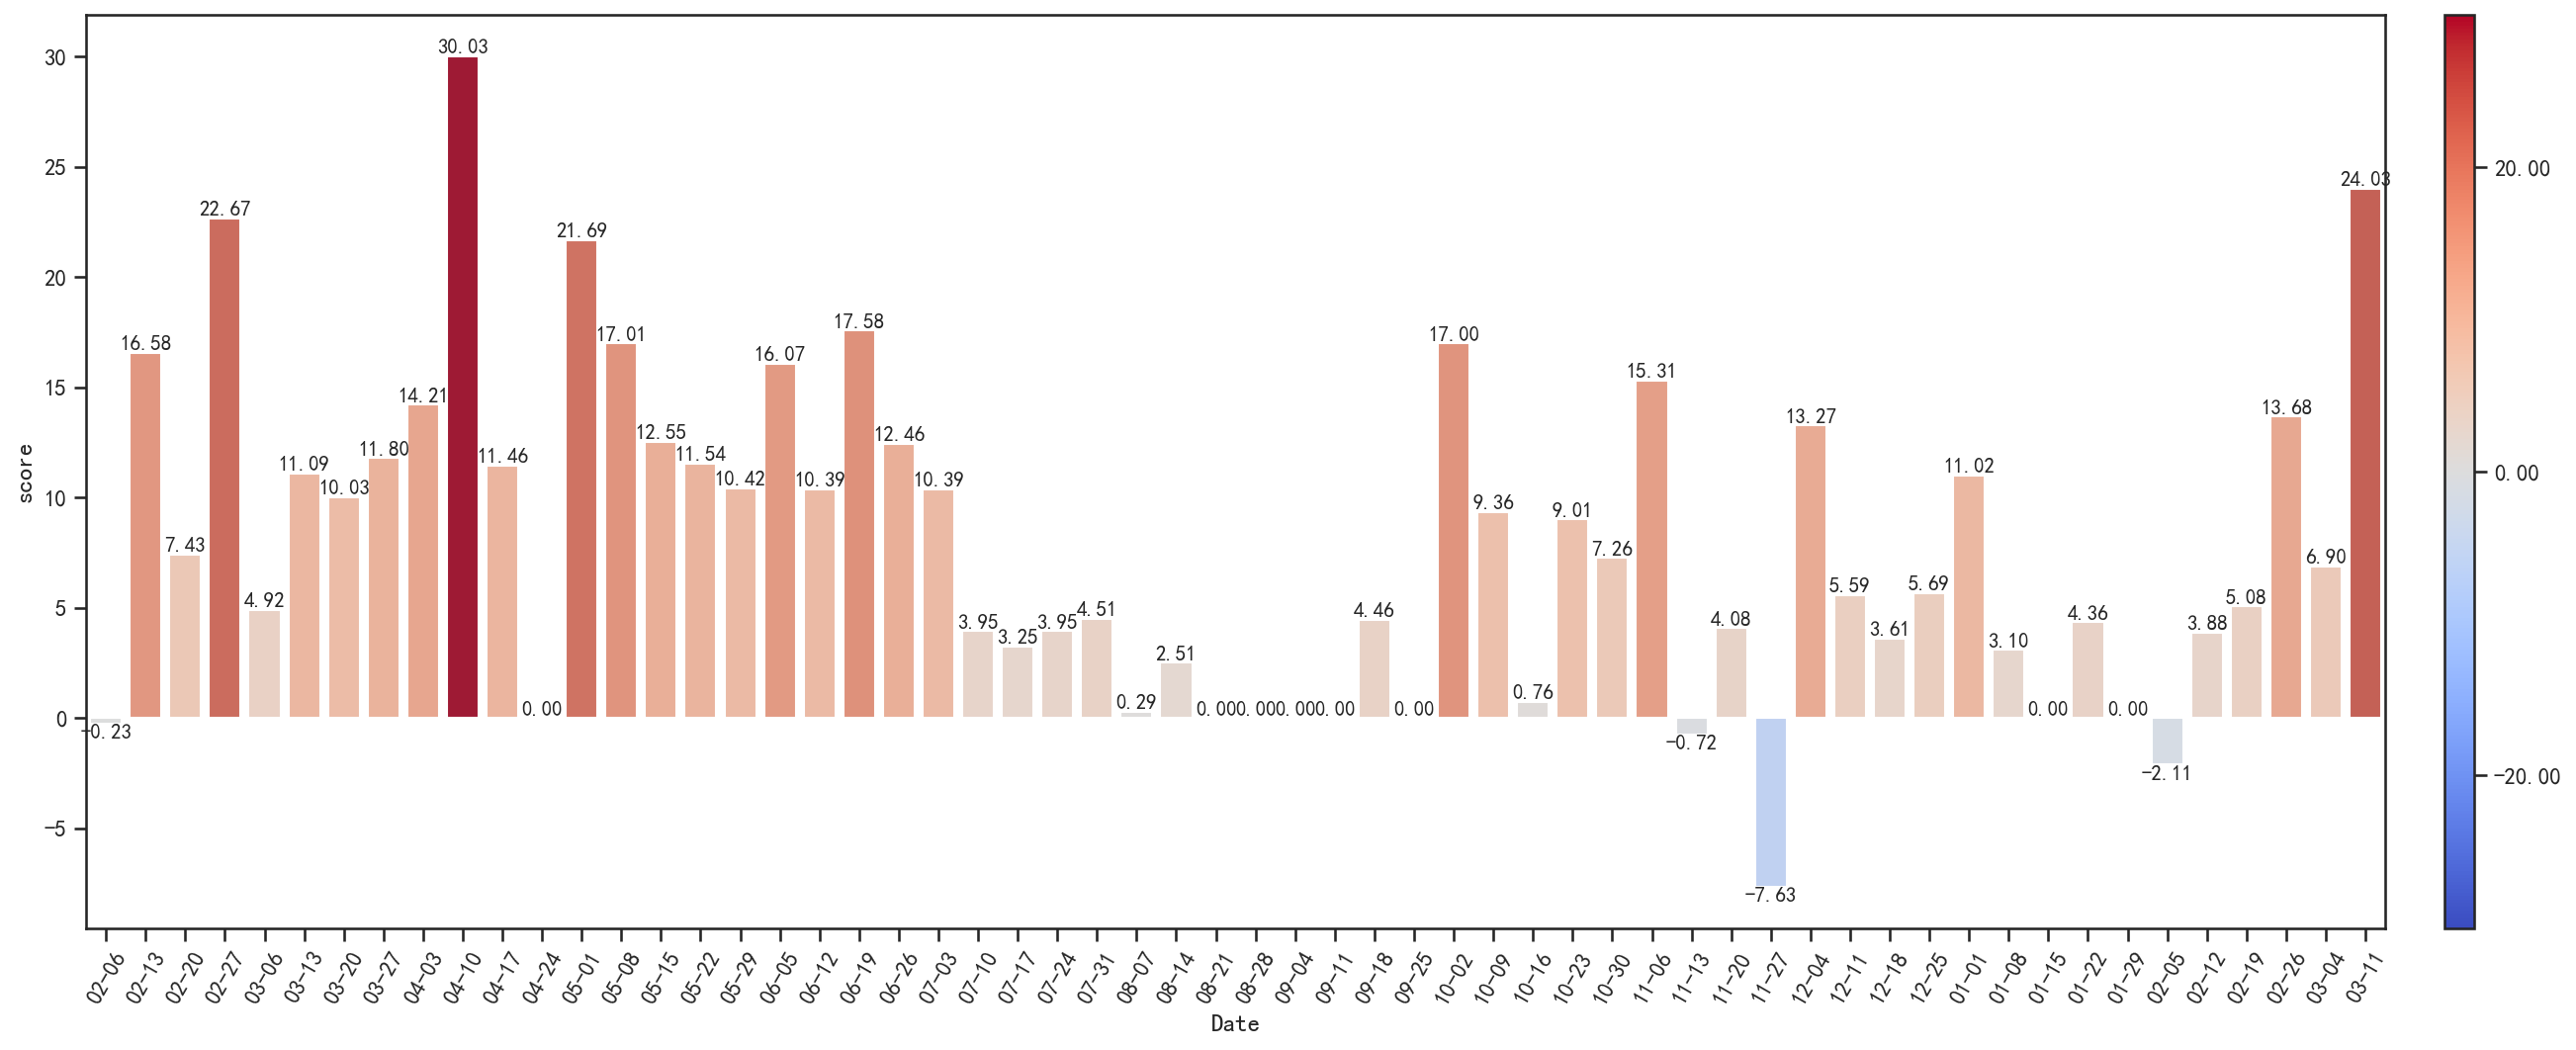

In [83]:
totSenScore0 = weekTotSenScore(dfEs[0])

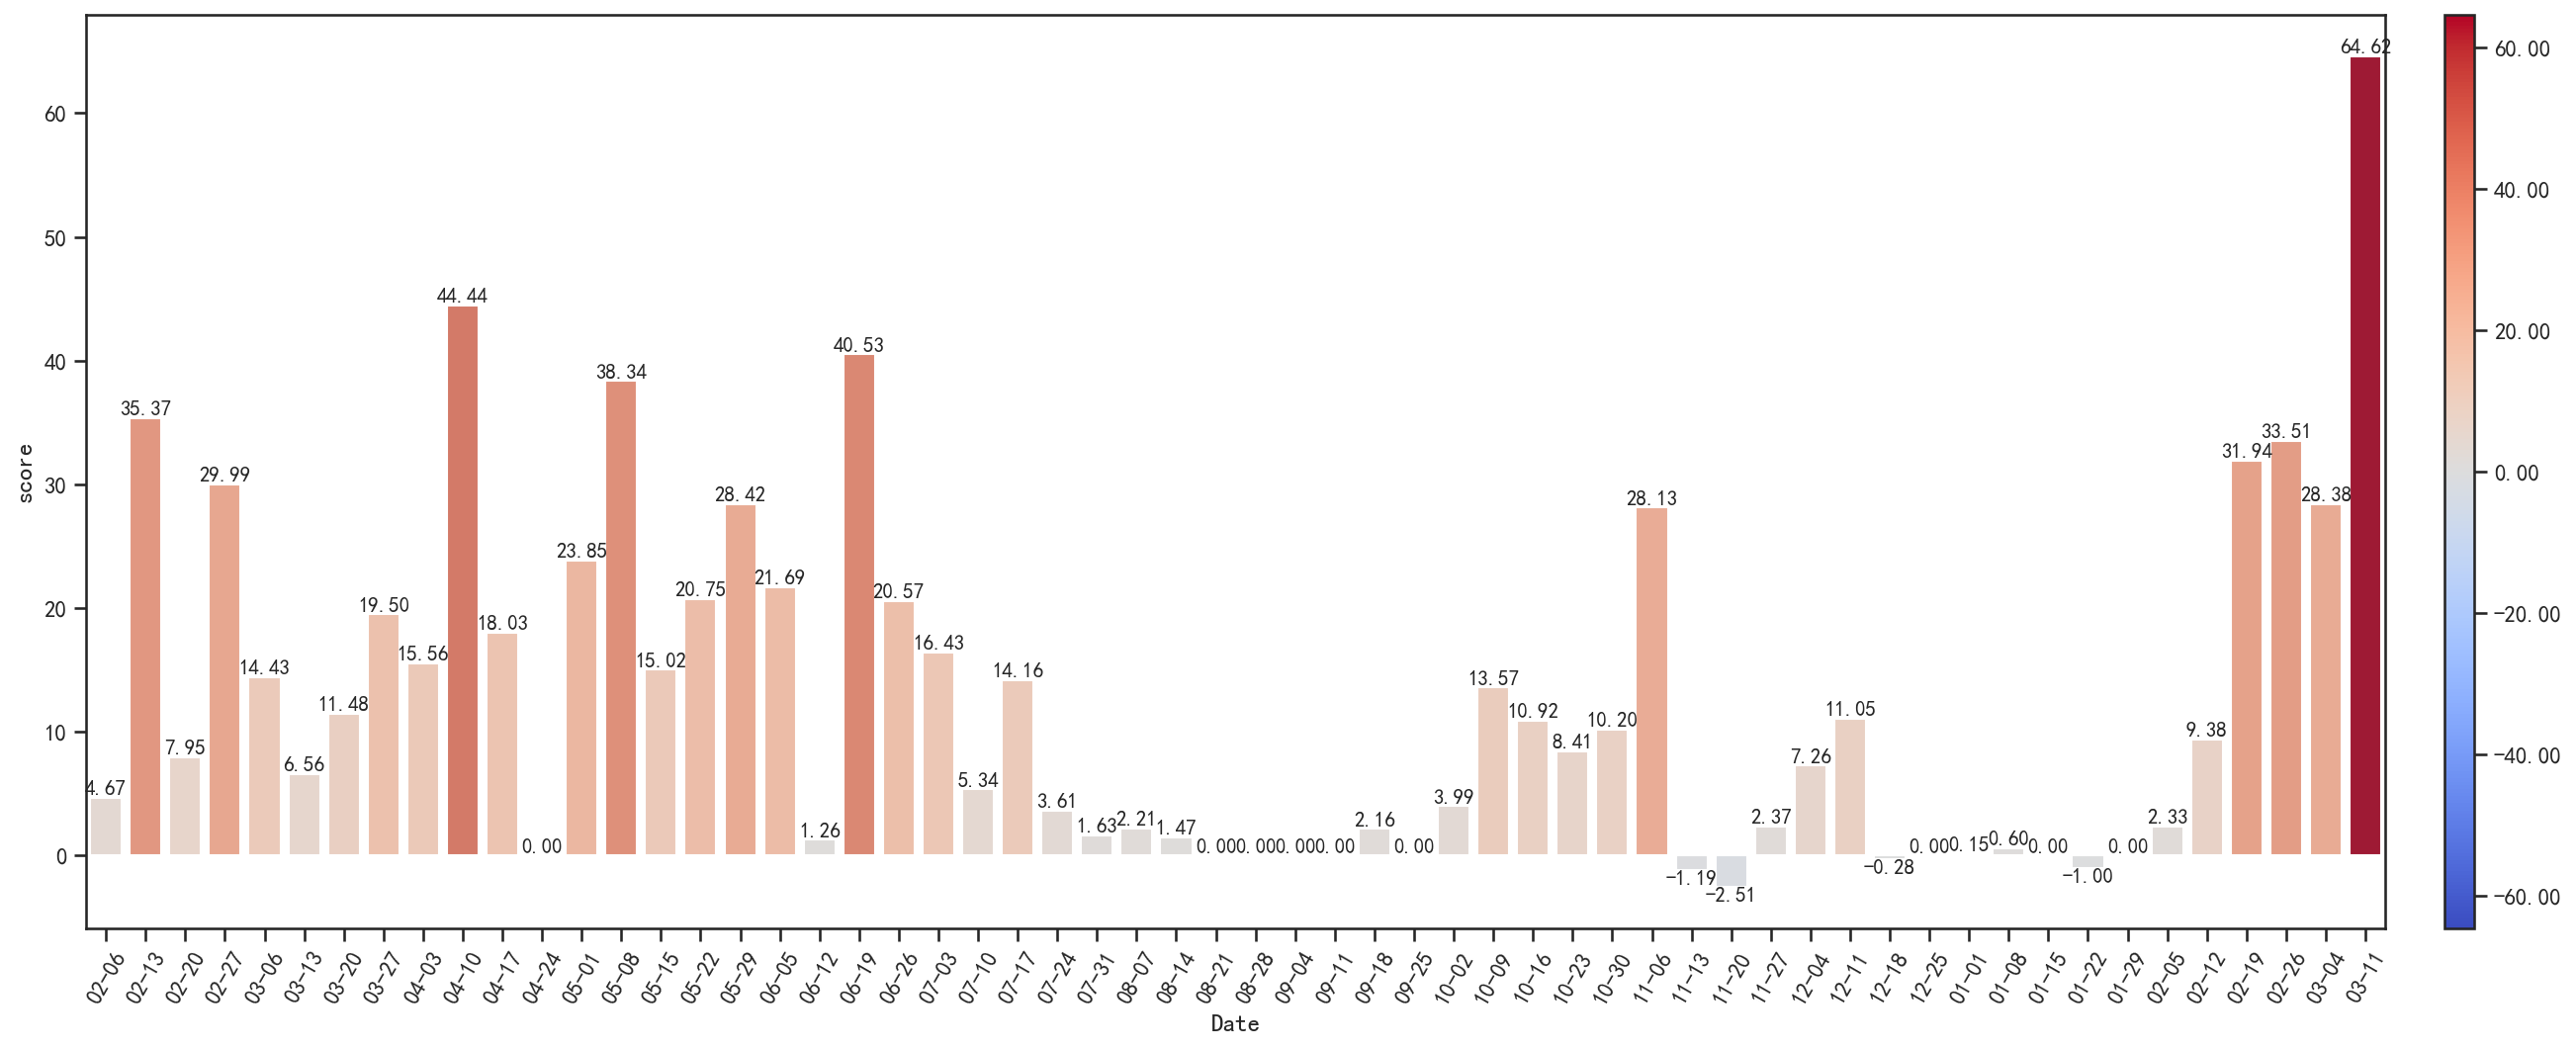

In [84]:
totSenScore1 = weekTotSenScore(dfEs[1])

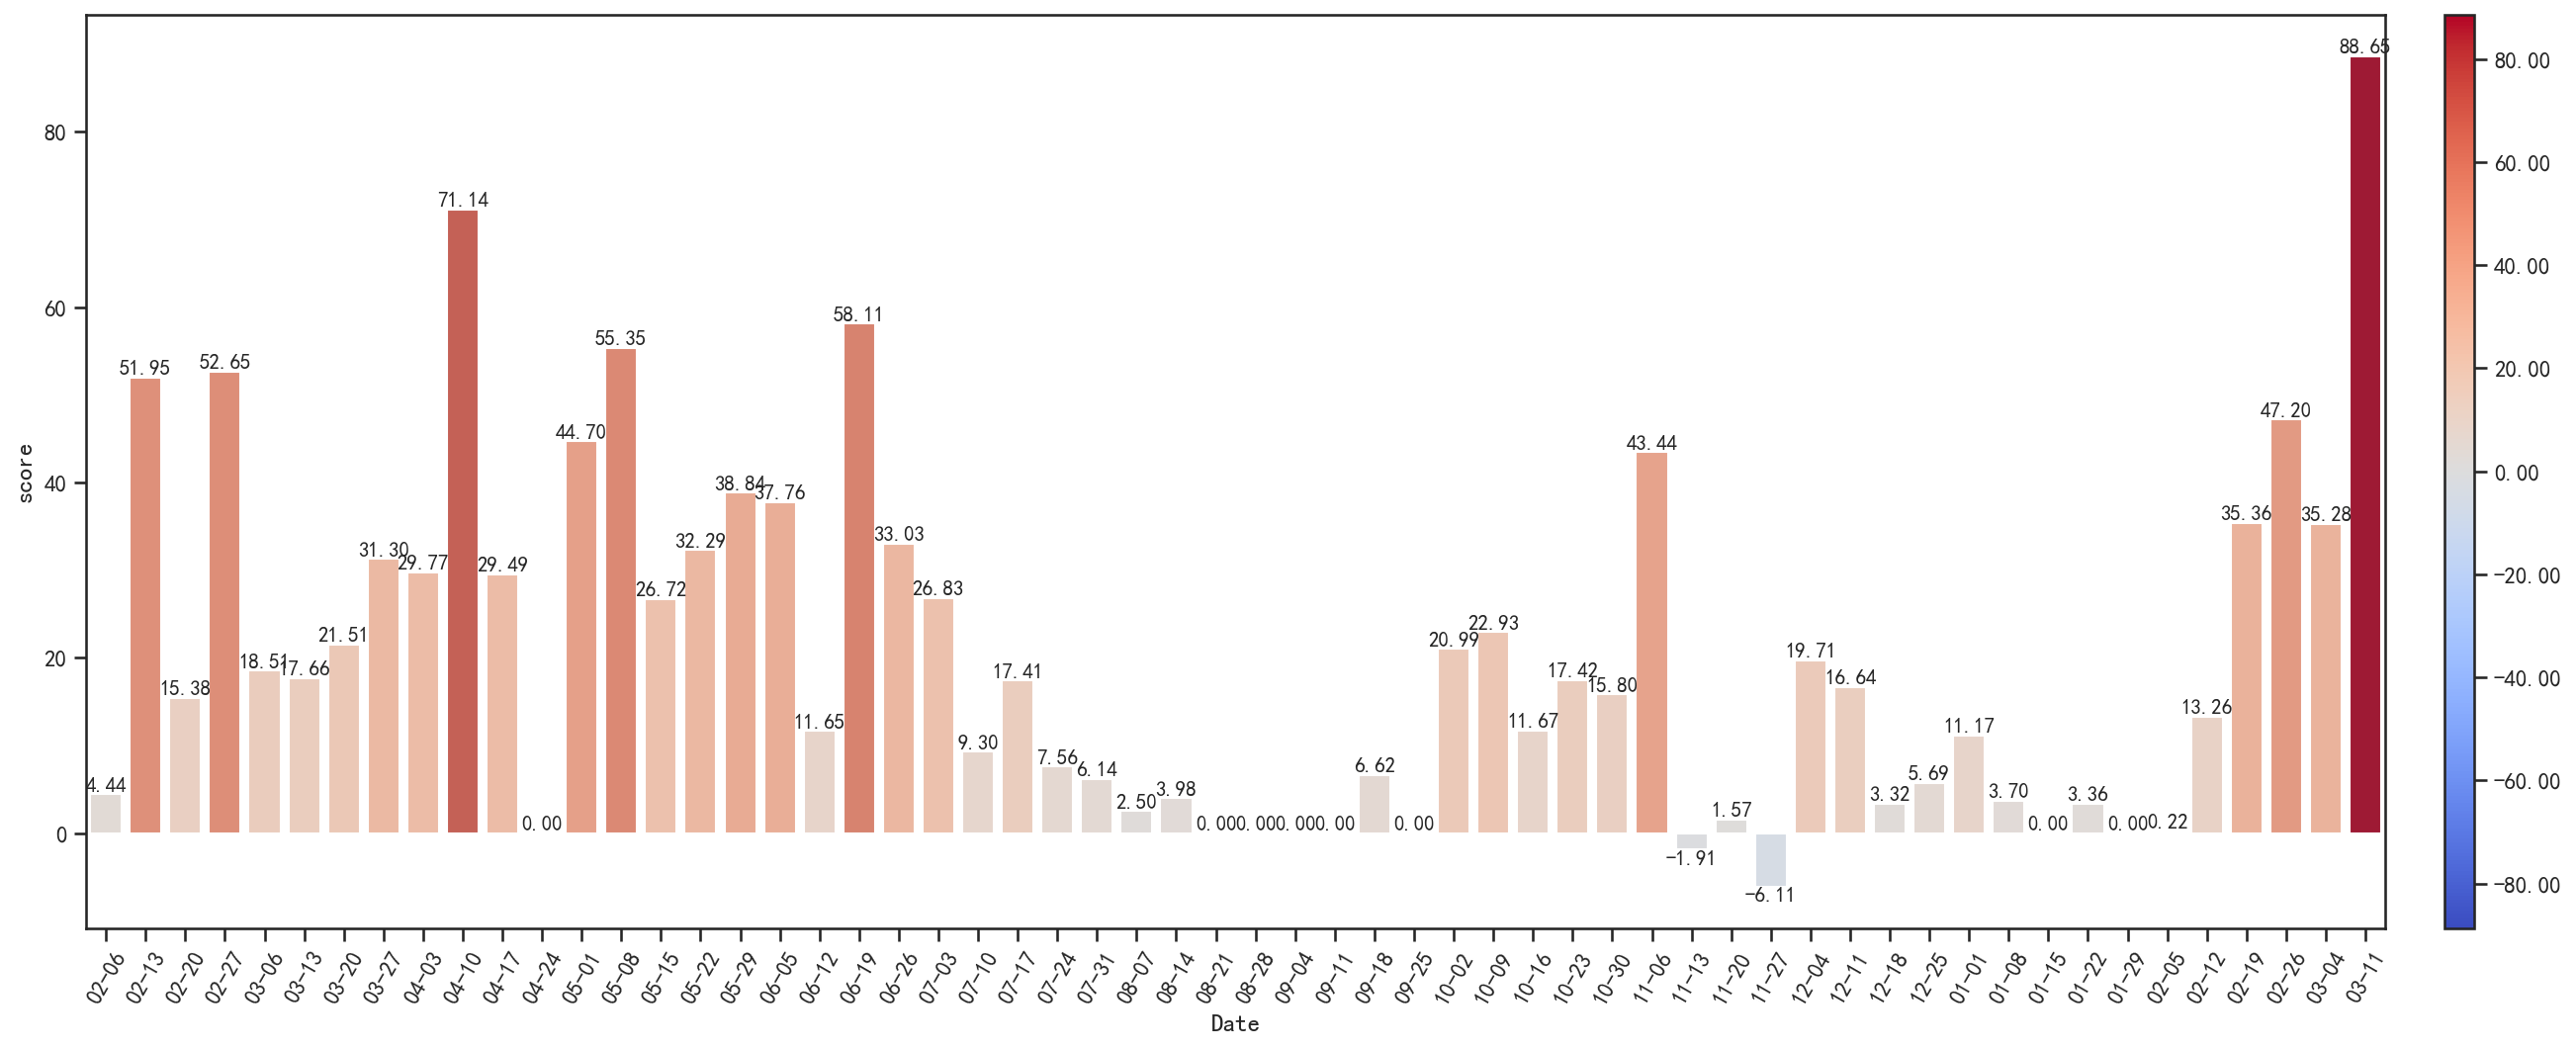

In [85]:
_ = weekTotSenScore(dfE)

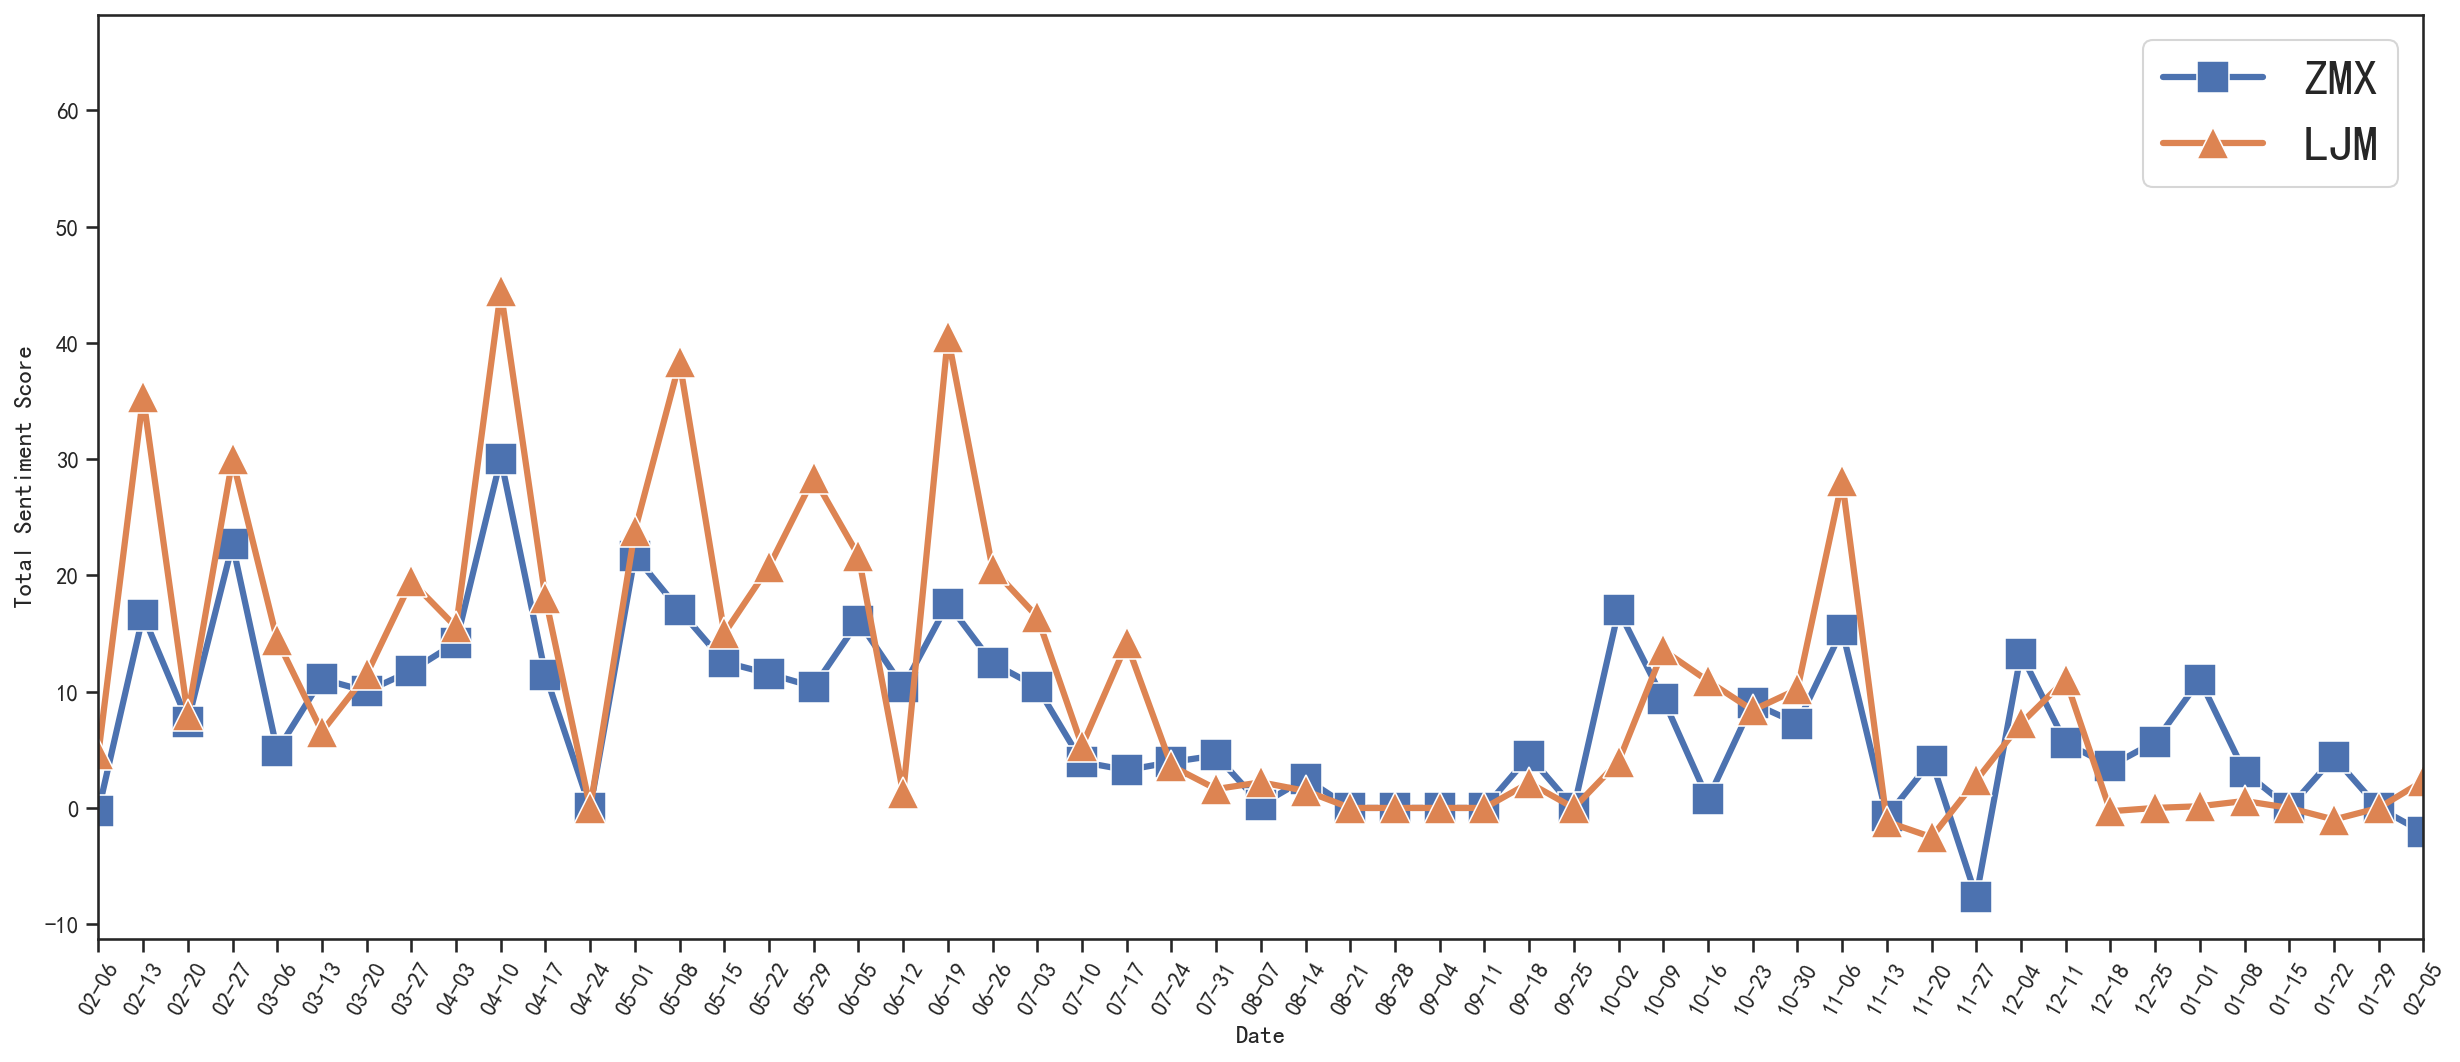

In [86]:
ax = sns.lineplot(data=totSenScore0, linewidth=3, marker="s", markersize=15, label=labels[0])
ax = sns.lineplot(data=totSenScore1, linewidth=3, marker="^", markersize=15, ax=ax, label=labels[1])

ax.set_xlabel("Date")
plt.xticks(rotation=60)
ax.set_ylabel("Total Sentiment Score")
ax.set_xlim(0, 52)
ax.legend(prop={"size": 24})

ax.figure.set_size_inches(20, 8)
ax.figure.set_dpi(150)
plt.show()
plt.close()

### 每日平均情感分析

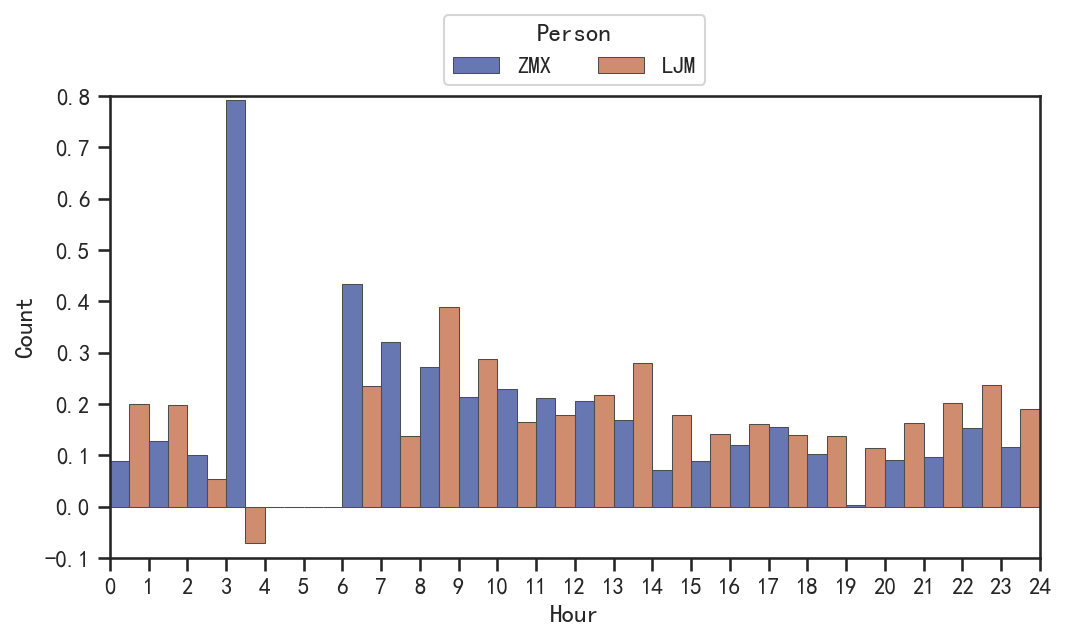

In [132]:
grouper = pd.Grouper(key="hour")

data = []
for k in range(2):
    tmp = dfEs[k].groupby(grouper)["score"].mean().sort_index()
    for i in range(24):
        if i in tmp.index:
            data.append(tmp[i])
        else:
            data.append(0)
    data.append(0)
data = pd.DataFrame(
    {
        "Score": data,
        "Person": [labels[0]] * 25 + [labels[1]] * 25,
    }
)

xBins = [i for i in range(25)]
ax = sns.histplot(
    data=data,
    x=xBins * 2,
    bins=xBins,
    weights="Score",
    hue="Person",
    multiple=multiple,
    edgecolor=".3",
    linewidth=0.5,
    palette="dark",
    alpha=0.6,
)

ax.set_xticks(range(25))
ax.set_xticklabels(range(25))
ax.set_xlabel("Hour")
ax.set_xlim(0, 24)
ax.set_ylim(np.min([0, np.floor(data["Score"].min() / 0.05) * 0.05]), np.ceil(data["Score"].max() / 0.05) * 0.05)
sns.move_legend(ax, loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)

ax.figure.set_size_inches(8, 4)
ax.figure.set_dpi(150)
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体
# plt.title('每日平均情感分析', fontsize=16)  
plt.savefig(r'C:\Users\admin\Documents\test\导出文件\imgs\13.png')
plt.show()
plt.close()

### 每日累计情感分析

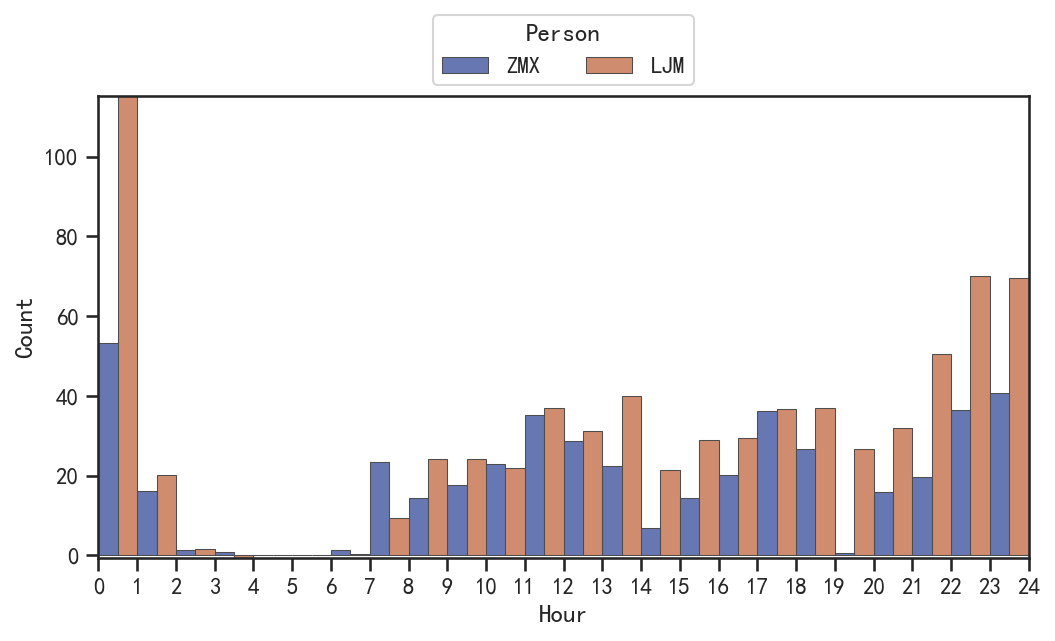

In [133]:
grouper = pd.Grouper(key="hour")

data = []
for k in range(2):
    tmp = dfEs[k].groupby(grouper)["score"].sum().sort_index()
    for i in range(24):
        if i in tmp.index:
            data.append(tmp[i])
        else:
            data.append(0)
    data.append(0)
data = pd.DataFrame(
    {
        "Score": data,
        "Person": [labels[0]] * 25 + [labels[1]] * 25,
    }
)

xBins = [i for i in range(25)]
ax = sns.histplot(
    data=data,
    x=xBins * 2,
    bins=xBins,
    weights="Score",
    hue="Person",
    multiple=multiple,
    edgecolor=".3",
    linewidth=0.5,
    palette="dark",
    alpha=0.6,
)

ax.set_xticks(range(25))
ax.set_xticklabels(range(25))
ax.set_xlabel("Hour")
ax.set_xlim(0, 24)
ax.set_ylim(np.min([0, np.floor(data["Score"].min() / 0.05) * 0.05]), np.ceil(data["Score"].max() / 0.05) * 0.05)
sns.move_legend(ax, loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)

ax.figure.set_size_inches(8, 4)
ax.figure.set_dpi(150)
plt.savefig(r'C:\Users\admin\Documents\test\导出文件\imgs\14.png')
plt.show()
plt.close()